**What are Biomarkers?**
Biomarkers (short for biological markers) are measurable indicators of some biological state or condition. In the context of developmental disorders and scRNA-seq data, biomarkers are specific genes, proteins, or other molecules whose presence, absence, or activity levels indicate a particular developmental stage or a potential disorder.

**Step 1:Load Required Libraries**

In [1]:
#Install necessary Python packages required for scRNA-seq analysis.
!pip install scanpy anndata seaborn scikit-learn --quiet
!pip install torch-geometric -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00


In [2]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set visualization style
sns.set_style("whitegrid")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the dataset
file_path = '/content/drive/MyDrive/GSE155121_human_data_raw.h5ad'
# Load the dataset
adata = sc.read_h5ad(file_path)

# Show basic info
print(adata)
print("Dataset Loaded Successfully!")


AnnData object with n_obs × n_vars = 463304 × 32738
    obs: 'week_stage'
    var: 'gene_ids', 'feature_types-1-0-0-0-0-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0'
Dataset Loaded Successfully!


In [5]:
# Show all column names in cell-level metadata
adata.obs.columns.tolist()


['week_stage']

<ipython-input-6-7eb2ae852d5c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='week_stage', data=adata.obs, palette='Set2', dodge=False)


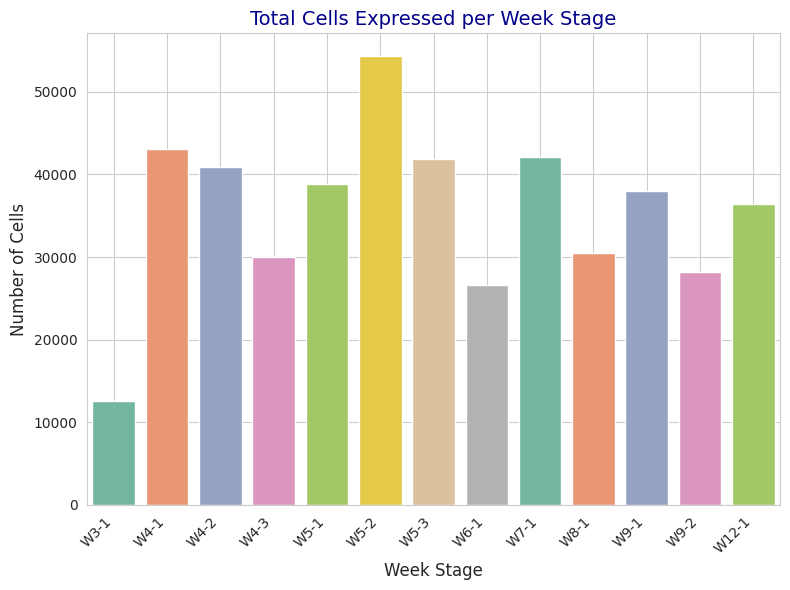

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

week_stage_counts = adata.obs['week_stage'].value_counts()

# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='week_stage', data=adata.obs, palette='Set2', dodge=False)
plt.title('Total Cells Expressed per Week Stage', fontsize=14, color='darkblue')
plt.xlabel('Week Stage', fontsize=12)
plt.ylabel('Number of Cells', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

W5-2 has the highest number of cells (~54,000), making it the most sampled stage.

W3-1 has the lowest number of cells (~12,000), indicating limited data for that earliest time point.

Overall, the dataset is fairly balanced across stages but has slight variation

<ipython-input-7-b1987413bf6a>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=week_stage_gene_counts.index, y=week_stage_gene_counts.values, palette='Set2', dodge=False)


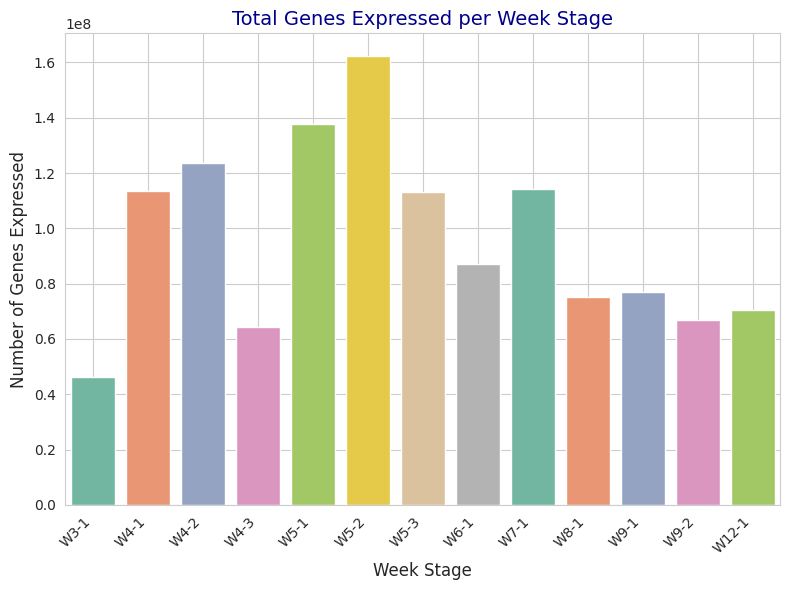

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the total number of genes expressed in each cell
adata.obs['n_genes_by_counts'] = (adata.X > 0).sum(axis=1)

# Calculate the total number of genes expressed in each week stage
week_stage_gene_counts = adata.obs.groupby('week_stage', observed=False)['n_genes_by_counts'].sum()

# Create a bar plot
plt.figure(figsize=(8, 6))
# Set legend=False to suppress the FutureWarning (or assign hue and set legend=False)
ax = sns.barplot(x=week_stage_gene_counts.index, y=week_stage_gene_counts.values, palette='Set2', dodge=False)
plt.title('Total Genes Expressed per Week Stage', fontsize=14, color='darkblue')
plt.xlabel('Week Stage', fontsize=12)
plt.ylabel('Number of Genes Expressed', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


W5-2 again has the highest gene expression activity, with ~160 million expression events — expected since it also had the most cells.

W3-1 shows the lowest — reflecting both fewer cells and possibly lower transcriptional activity at that earliest stage.

There's a drop in later stages (e.g., W9-2, W12-1), which may reflect fewer cells or changes in gene expression dynamics during maturation.

adata.X > 0
This creates a boolean matrix the same size as your gene expression matrix.

For each cell × gene, it returns:

True (or 1) if the gene is expressed (non-zero)

False (or 0) if not expressed

In [8]:
# Summarizing dataset structure
print("Dataset Summary:")
print(f"Number of cells: {adata.n_obs}, Number of genes: {adata.n_vars}")
print("First few cell observations:")
display(adata.obs.head())
print("First few gene features:")
display(adata.var_names[:10])
print("Shape of raw dataset:", adata.X.shape)

# Convert adata.X to a dense NumPy array before checking for NaN
print("Total Missing Values in Dataset:", np.isnan(adata.X.toarray()).sum()) # The toarray() method converts a sparse matrix to a dense NumPy array.

Dataset Summary:
Number of cells: 463304, Number of genes: 32738
First few cell observations:


,week_stage,n_genes_by_counts
index,,
AAACCTGAGAATGTTG-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1,3476
AAACCTGAGCCAGAAC-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1,3880
AAACCTGAGGCAGTCA-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1,4646
AAACCTGAGGGATGGG-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1,4258
AAACCTGAGTGACATA-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1,3743


First few gene features:


Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10'],
      dtype='object', name='index')

Shape of raw dataset: (463304, 32738)
Total Missing Values in Dataset: 0


In [9]:
!pip install scikit-misc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 3.9 MB/s eta 0:00:00


An implementation of LOESS smoothing (Locally Estimated Scatterplot Smoothing), which is often used to fit smooth curves through noisy biological data — e.g., gene expression trends across developmental stages.

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


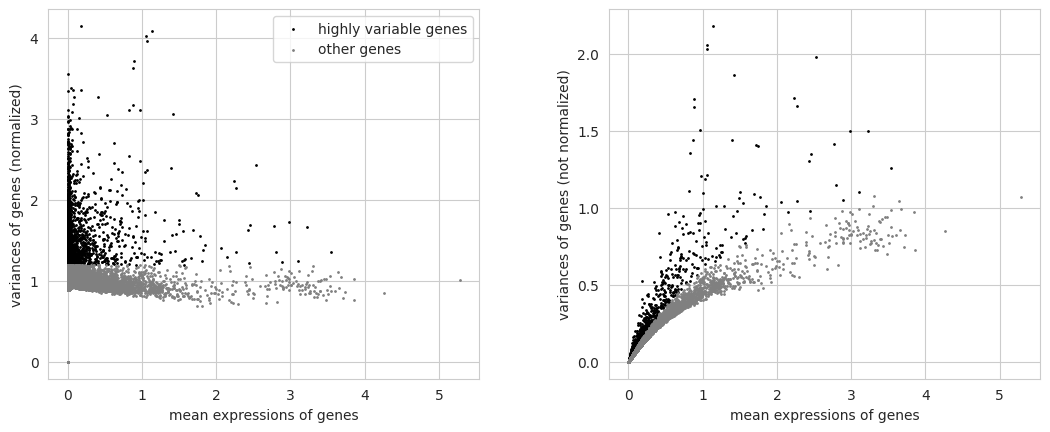

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
# Convert the sparse matrix to a dense array for the check
if np.any(adata.X.toarray() < 0):  # Log transformation should not have negative values
    print("Data is already log-transformed, skipping log1p step.")
else:
    sc.pp.log1p(adata)

# Identifying Highly Variable Genes
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)
# Selects 2000 highly variable genes (HVGs) using the Seurat v3 method.
#These are genes that: Show high biological variation (not just noise) and are informative for clustering


# Visualizing highly variable genes
sc.pl.highly_variable_genes(adata)

# Filter only the highly variable genes
adata = adata[:, adata.var.highly_variable]

# Scaling Data
sc.pp.scale(adata, max_value=10)
# Standardizes each gene so they’re on the same scale for PCA or ML. Clipping extreme values to ±10 avoids outlier bias.


adata.X is your gene expression matrix (cells × genes). It's often stored in a sparse format to save memory.

.toarray() converts it to a dense NumPy array so we can apply standard operations like comparison.

np.any(adata.X.toarray() < 0) checks if any values are negative.

Why? If your data is already log-transformed (like log1p), it shouldn't have any negative values.

So if you detect negative values, you don't apply log1p again.

image 2: There's a strong relationship between mean and variance — genes with higher means also have higher variance.

This is mostly due to technical effects, not biology.

That’s why we normalize and log-transform: to flatten this curve and reveal true biological variability

image 1: Low average expression (they're barely active)

Low variance (they behave similarly across all cells)

But some genes:

Have a moderate average expression

Show high variance across cells

sc.pl.highly_variable_genes(adata) 🔍 Explanation: This creates a plot showing:

All genes, their mean expression vs. variability

Which genes were selected as "highly variable" (highlighted)

Useful for QC to ensure HVG selection makes sense.

Explanation: This filters your AnnData object to only keep the selected HVGs:

: → keep all rows (cells)

adata.var.highly_variable → only keep columns (genes) marked as True

This reduces memory and noise by focusing on the genes that matter most.

sc.pp.scale(adata, max_value=10) 🔍 Explanation: Standardizes each gene (column) across all cells:

Subtracts mean

Divides by standard deviation → mean = 0, std = 1

max_value=10 clips all values to the range [-10, +10]:

Prevents extreme outliers from skewing PCA or clustering

Seurat v3 introduced a method to identify highly variable genes by:

Binning genes based on average expression

Calculating variance within each bin

Standardizing variance (z-scores) to remove bias toward highly expressed genes

Seurat v3’s Key Innovation: "Variance-stabilized selection of highly variable genes"

Instead of just picking genes with the highest raw variance, Seurat v3:

Calculates mean expression and variance for each gene

Models the expected variance as a function of the mean

Finds genes whose variance is much higher than expected

Selects the top N most variable as HVGs

This method:

Removes technical noise

Keeps biologically meaningful variation

The Seurat method is a popular approach for analyzing single-cell RNA-seq data. It includes log-normalization, identification of highly variable genes (HVGs), data scaling, and dimensionality reduction. In Seurat v3, HVGs are selected by comparing gene variability relative to their average expression, helping focus on biologically informative genes. This method is widely used for clustering cells and visualizing gene expression patterns, and is also implemented in Python tools like Scanpy using the "seurat_v3" option.

Works better across datasets with different depths

In [11]:
# Display dataset info
print(adata)
print("Data Preprocessing Completed!")

AnnData object with n_obs × n_vars = 463304 × 2000
    obs: 'week_stage', 'n_genes_by_counts'
    var: 'gene_ids', 'feature_types-1-0-0-0-0-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
Data Preprocessing Completed!


In [12]:
# Step 4: Exploratory Data Analysis (EDA)
# Summary of Metadata
print("Available Metadata Columns:", adata.obs.columns)
print("Dataset Overview:")
print(adata.obs.head())


Available Metadata Columns: Index(['week_stage', 'n_genes_by_counts'], dtype='object')
Dataset Overview:
                                           week_stage  n_genes_by_counts
index                                                                   
AAACCTGAGAATGTTG-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1               3476
AAACCTGAGCCAGAAC-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1               3880
AAACCTGAGGCAGTCA-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1               4646
AAACCTGAGGGATGGG-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1               4258
AAACCTGAGTGACATA-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1               3743


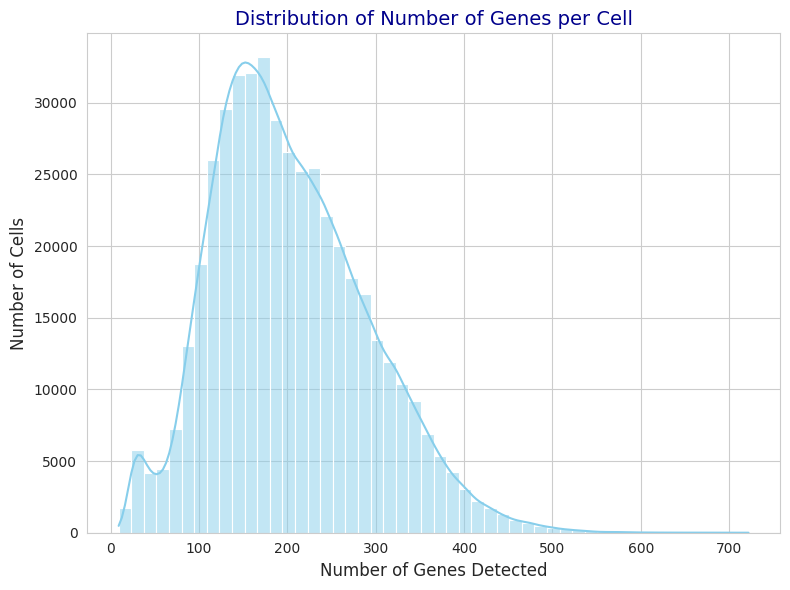

In [13]:
# Calculate the number of genes expressed in each cell
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1)

# Plot the distribution using seaborn for better visual quality
plt.figure(figsize=(8, 6))
sns.histplot(adata.obs['n_genes'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Number of Genes per Cell', fontsize=14, color='darkblue')
plt.xlabel('Number of Genes Detected', fontsize=12)
plt.ylabel('Number of Cells', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Most cells express 150–400 genes, with a peak around 250. Cells with very low counts may be low-quality, while those with very high counts could be doublets. This helps set thresholds to filter out poor-quality cells before analysis.

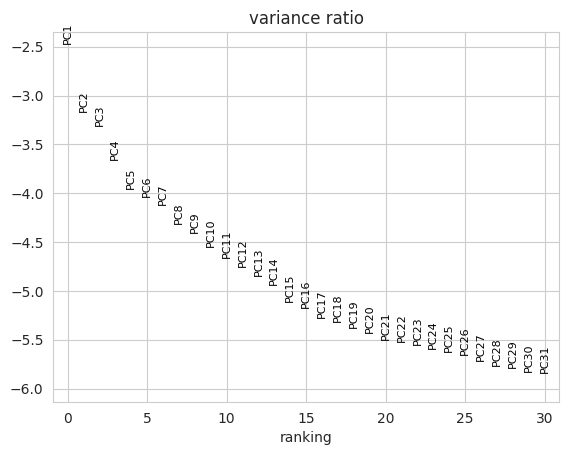

In [14]:
#  PCA for Dimensionality Reduction
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

PC1–PC5 explain most of the variance (steep drop). PC6–PC15 still contribute meaningful variance, but less. PC16 onward show diminishing returns — mostly noise. This "elbow" shape is common — it helps you choose how many PCs to keep.

The svd_solver='arpack' option in PCA uses an efficient iterative method to compute only the top principal components. It is ideal for large, sparse datasets like scRNA-seq, as it reduces memory usage and speeds up computation while preserving key patterns in the data.

In [15]:
sc.pp.neighbors(adata, n_pcs=20)


To create a graph where:

Each node = a gene

Each edge = a significant correlation between two genes

This graph can then be used for models like GAT to capture gene-gene relationships

In [18]:
# Step 5: Construct Graph Representation
# Convert gene expression data into a graph structure

def build_gene_interaction_graph(adata):
    G = nx.Graph()
    genes = list(adata.var_names)

    # Add nodes (genes)
    for gene in genes:
        G.add_node(gene)

    # Define edges based on correlation
    expression_matrix = adata.X.T  # Transpose to have genes as rows and cells are coloumns
    correlation_matrix = np.corrcoef(expression_matrix)

    threshold = 0.7  # Adjust for significant correlations
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            if correlation_matrix[i, j] > threshold:
                G.add_edge(genes[i], genes[j], weight=correlation_matrix[i, j])

    return G

G = nx.Graph() Initializes an empty undirected graph genes = list(adata.var_names) Gets all gene names G.add_node(gene) Adds each gene as a node adata.X.T Transposes the matrix so each row = gene across all cells np.corrcoef(...) Calculates pairwise Pearson correlation between genes if correlation > 0.7: Adds an edge only if two genes are strongly co-expressed

Builds a gene interaction network based on expression correlation.

Each gene is a node, and highly correlated pairs are connected by an edge.

Edge weights = correlation coefficient.

In [17]:
# Build graph
gene_graph = build_gene_interaction_graph(adata)
print(f"Graph constructed with {gene_graph.number_of_nodes()} nodes and {gene_graph.number_of_edges()} edges.")

Graph constructed with 2000 nodes and 519 edges.


Out of all 1,999,000 possible edges in a 2000-node graph:

I found only 519 strong correlations with correlation > 0.7 — which means graph is very sparse and selective

**To convert a NetworkX graph (based on gene correlations) into a format (Data) that PyTorch Geometric understands.**

In [19]:
# Step 6: Convert Graph to PyTorch Geometric Format

def convert_to_pyg_data(graph):
    node_index = {node: i for i, node in enumerate(graph.nodes())} #Assigns a unique integer ID to each gene (node),
    #since PyTorch Geometric uses integer-based indexing.

    # Will store the edges and their weights.
    edge_index = [] # which nodes are connected
    edge_attr = [] # how strong the connection is (correlation value)

    # For each edge between genes u and v, add:
    for u, v, data in graph.edges(data=True):
        edge_index.append([node_index[u], node_index[v]]) # Their corresponding indices to edge_index
        edge_attr.append(data['weight']) # The correlation strength to edge_attr

    # Converts the list of edges into a PyTorch tensor, transposed to match required shape
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float) # Stores the correlation weights of the edges as float values.

    # Convert gene expression data into PyTorch tensor
    x = torch.tensor(adata.X, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr) # Packs everything into a PyTorch Geometric Data object, ready for training with GAT.
    return data

In [20]:
# Convert to PyTorch Geometric format
gene_graph_data = convert_to_pyg_data(gene_graph)
print("Graph successfully converted to PyTorch Geometric format!")

Graph successfully converted to PyTorch Geometric format!


**This GAT model learns from your gene–gene graph to predict developmental stages or other labels associated with each gene node.**

In [22]:
# Step 7: Implement Graph Attention Network (GAT)
class GATModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=3):
        super(GATModel, self).__init__() # below are two attention layers
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True) # First GAT layer: applies multi-head attention (3 heads).
                                                                              # concat=True: output from each head is concatenated, increasing the dimensionality.

        self.conv2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False) # Second GAT layer: uses 1 attention head, outputs class logits.
                                                                                    # concat=False: here the attention head outputs are averaged instead of concatenated.
# This defines a 2-layer GAT using PyTorch and PyTorch Geometric.
# input_dim = size of each node’s feature vector (e.g. number of genes)
# hidden_dim = number of hidden units per head
# output_dim = number of classes (e.g. 13 developmental stages)
# heads=3 = number of attention heads in the first layer


# How Data Moves Through the Network
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index)) # Applies the first GAT layer with ELU activation.
        x = self.conv2(x, edge_index) # Second GAT layer outputs raw class scores.
        return F.log_softmax(x, dim=1) # used F.log_softmax(x, dim=1) at the end of your GAT model
        # to convert the model's raw output (logits) into log-probabilities for each class.

In [25]:
# Define Model Parameters
input_dim = gene_graph_data.x.shape[1]
hidden_dim = 64
output_dim = len(set(adata.obs['week_stage']))  # Assuming week_stage as target labels (13 classes)

I chose a hidden dimension of 64 as a balanced size that offers sufficient learning capacity for modeling gene interactions without making the model too heavy or prone to overfitting.

In [26]:
import torch.optim as optim

In [27]:
# Initialize Model
gat_model = GATModel(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)
# Adam optimizer, a popular choice for training deep learning models.
# lr=0.01: sets the learning rate (how big the updates are).
# weight_decay=5e-4: adds L2 regularization to prevent overfitting by penalizing large weights.
criterion = torch.nn.NLLLoss() # Defines the loss function: Negative Log-Likelihood Loss.

I used the Adam optimizer because it is well-suited for training deep learning models on sparse and high-dimensional data like scRNA-seq. Adam adapts the learning rate for each parameter, helping the model converge faster and more reliably than traditional stochastic gradient descent (SGD). I set the learning rate to 0.01, which is a commonly used starting point for Adam, balancing stability and speed of learning. Typical learning rates for Adam range between 0.0001 and 0.01. While alternatives like SGD, RMSprop, and AdamW exist, Adam is often preferred for graph neural networks due to its robustness and efficiency.

I used log_softmax with NLLLoss because this combination is standard and stable for multi-class classification. It lets me explicitly control the activation and aligns with what NLLLoss expects — log-probabilities. This setup is especially common in graph-based models like GAT, where we often prefer full transparency and control over each step.

I used NLLLoss (Negative Log Likelihood Loss) as the loss function because my GAT model outputs class probabilities using log_softmax. NLLLoss is specifically designed to work with log-probabilities, making it the appropriate choice for multi-class classification problems like predicting developmental stages. If the model had used softmax instead, CrossEntropyLoss would have been the better option, but in this setup, NLLLoss aligns perfectly with the final activation function.

In [28]:
import torch.nn.functional as F

In [29]:
from sklearn.preprocessing import LabelEncoder # converts categorical labels into numerical pcw 3-0 pcw4-1

“Which gene expressions help me tell week 4 vs week 8 cells apart?” (cell-based)

In [30]:
# Step 8: Train GAT Model with Training & Validation Splitting
def train_model(model, data, epochs=25, patience=10):
    model.train()
    encoder = LabelEncoder()

    if 'week_stage_encoded' not in adata.obs.columns:
        adata.obs['week_stage_encoded'] = encoder.fit_transform(adata.obs['week_stage'])

    # Split indices into training (80%) and validation (20%)
    indices = np.arange(len(adata)) # Creates an array of all cell indices
    np.random.shuffle(indices) # Shuffles them randomly.
    split_idx = int(0.8 * len(indices)) # Splits the shuffled indices: 80% for training, 20% for validation.
    train_indices, val_indices = indices[:split_idx], indices[split_idx:]

    # Split the dataset into training and validation sets
    train_x = data.x[train_indices] # Selects the node features (x) for training and validation nodes.
    val_x = data.x[val_indices]

    train_labels = torch.tensor(adata.obs['week_stage_encoded'].values[train_indices], dtype=torch.long)
    val_labels = torch.tensor(adata.obs['week_stage_encoded'].values[val_indices], dtype=torch.long)
    # Converts the encoded week stage labels to PyTorch tensors for both sets.


    # Set Up Early Stopping and Tracking
    best_loss = float('inf') # Best validation loss so far
    epochs_without_improvement = 0
    loss_history, accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []

    # Training Loop
    for epoch in range(epochs): # Loops over each epoch.
        optimizer.zero_grad() # Resets gradients before each training step
        out = model(Data(x=train_x, edge_index=data.edge_index, edge_attr=data.edge_attr))
        # Runs the model on the training data (train_x) using the shared graph (edge_index, edge_attr).
        loss = criterion(out, train_labels)
        loss.backward()
        optimizer.step()
        # Computes loss. Backpropagates gradients. Updates model weights

        # Store training loss & accuracy
        loss_history.append(loss.item())
        train_preds = out.argmax(dim=1).detach().cpu().numpy() # argmax(dim=1) picks the class with the highest score for each sample.
        # .detach() removes it from the computation graph
        # .cpu().numpy() moves the tensor to CPU and converts it to a NumPy array for compatibility with sklearn
        train_acc = accuracy_score(train_labels.cpu().numpy(), train_preds) # Compares the true labels (train_labels) to your predicted labels (train_preds).
        accuracy_history.append(train_acc) # Appends the training accuracy for this epoch to a list.
        # Logs training loss and accuracy using argmax to pick predicted class.


        # Validation step
        model.eval() # Switches the model to evaluation mode: disables dropout, batch norm updates, etc.
        with torch.no_grad(): # Disables gradient tracking to save memory and speed up inference
            val_out = model(Data(x=val_x, edge_index=data.edge_index, edge_attr=data.edge_attr))
            val_loss = criterion(val_out, val_labels)
            val_loss_history.append(val_loss.item())
            val_preds = val_out.argmax(dim=1).cpu().numpy()
            val_acc = accuracy_score(val_labels.cpu().numpy(), val_preds)
            val_accuracy_history.append(val_acc)
        model.train()

        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            # If the current validation loss is better than the best so far, update best_loss and reset the patience counter, Otherwise, increase the counter

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            break # If the model hasn't improved for patience epochs in a row, stop training early to avoid overfitting.

        if epoch % 5 == 0: # Every 5 epochs, prints
            print(f"Epoch {epoch}, Loss: {loss.item():.3f}, Accuracy: {train_acc:.3f}, Val Loss: {val_loss.item():.3f}, Val Accuracy: {val_acc:.3f}")

    return loss_history, accuracy_history, val_loss_history, val_accuracy_history

# Train the model
loss_history, accuracy_history, val_loss_history, val_accuracy_history = train_model(gat_model, gene_graph_data)


Epoch 0, Loss: 3.291, Accuracy: 0.062, Val Loss: 3.416, Val Accuracy: 0.435
Epoch 5, Loss: 0.826, Accuracy: 0.823, Val Loss: 0.774, Val Accuracy: 0.830
Epoch 10, Loss: 0.328, Accuracy: 0.920, Val Loss: 0.314, Val Accuracy: 0.927
Epoch 15, Loss: 0.202, Accuracy: 0.946, Val Loss: 0.201, Val Accuracy: 0.950
Epoch 20, Loss: 0.125, Accuracy: 0.964, Val Loss: 0.140, Val Accuracy: 0.963


An epoch is one full pass through the entire training dataset. We train over multiple epochs to allow the model to gradually learn patterns and improve accuracy. I used early stopping to avoid training for too many epochs and overfitting the model.

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_loss_curve(loss_history, val_loss_history, save_path=None):
    plt.figure(figsize=(6, 6))
    plt.plot(loss_history, label="Training Loss", color='tomato', linewidth=2)
    plt.plot(val_loss_history, label="Validation Loss", color='dodgerblue', linestyle='--', linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training vs Validation Loss", fontsize=14, weight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # is used in matplotlib to ensure that the x-axis ticks (labels) are integers only.
    # A locator that chooses tick locations and forces them to be integers.
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


def plot_accuracy_curve(accuracy_history, val_accuracy_history, save_path=None):
    plt.figure(figsize=(6, 6))
    plt.plot(accuracy_history, label="Training Accuracy", color='seagreen', linewidth=2)
    plt.plot(val_accuracy_history, label="Validation Accuracy", color='darkorange', linestyle='--', linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Training vs Validation Accuracy", fontsize=14, weight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


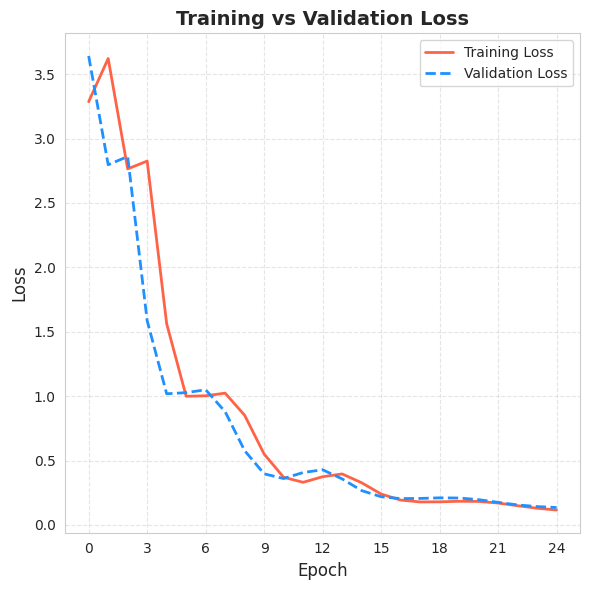

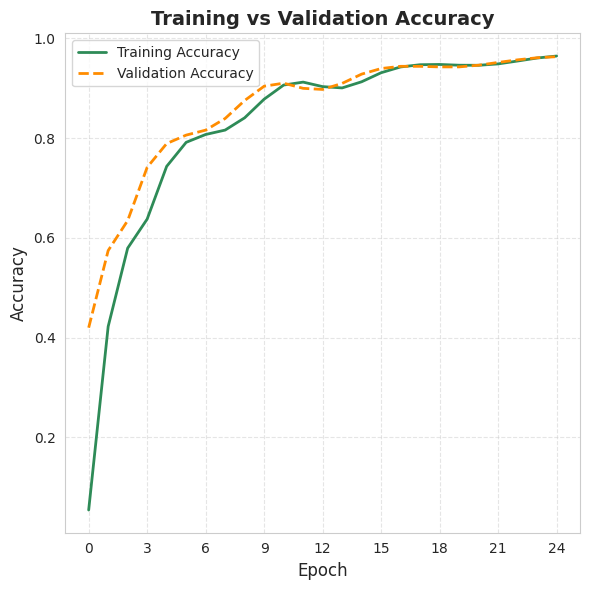

In [ ]:
plot_loss_curve(loss_history, val_loss_history)
plot_accuracy_curve(accuracy_history, val_accuracy_history)


In [40]:
print("Input dim:", gat_model.conv1.in_channels)
print("Hidden dim:", gat_model.conv1.out_channels)
print("Final out dim:", gat_model.conv2.out_channels)


Input dim: 2000
Hidden dim: 64
Final out dim: 13


In [32]:
# Get true labels for the entire dataset
true_labels = adata.obs['week_stage_encoded'].values

# Get predictions for the entire dataset
gat_model.eval()  # Set model to evaluation mode
with torch.no_grad():
    all_out = gat_model(gene_graph_data)  # Pass the entire graph data
    predictions = all_out.argmax(dim=1).cpu().numpy()

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_loss_curve(loss_history, val_loss_history, save_path=None):
    plt.figure(figsize=(6, 6))
    plt.plot(loss_history, label="Training Loss", color='tomato', linewidth=2)
    plt.plot(val_loss_history, label="Validation Loss", color='dodgerblue', linestyle='--', linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training vs Validation Loss", fontsize=14, weight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


def plot_accuracy_curve(accuracy_history, val_accuracy_history, save_path=None):
    plt.figure(figsize=(6, 6))
    plt.plot(accuracy_history, label="Training Accuracy", color='seagreen', linewidth=2)
    plt.plot(val_accuracy_history, label="Validation Accuracy", color='darkorange', linestyle='--', linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Training vs Validation Accuracy", fontsize=14, weight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


In [42]:
# Compute Accuracy
acc = accuracy_score(true_labels, predictions)
print(f"Model Accuracy: {acc:.4f}")

Model Accuracy: 0.9741


In [43]:
# Classification Report
print("Classification Report:\n", classification_report(true_labels, predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     36368
           1       0.99      1.00      0.99     12530
           2       0.99      0.99      0.99     43086
           3       0.98      0.95      0.96     40878
           4       0.98      0.99      0.99     30038
           5       1.00      0.99      0.99     38833
           6       0.99      0.99      0.99     54352
           7       0.98      0.99      0.99     41811
           8       0.98      0.97      0.98     26610
           9       0.94      0.95      0.95     42080
          10       0.96      0.96      0.96     30495
          11       0.96      0.97      0.97     38004
          12       0.96      0.95      0.96     28219

    accuracy                           0.97    463304
   macro avg       0.97      0.97      0.97    463304
weighted avg       0.97      0.97      0.97    463304



In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(true_labels, predictions, class_names=None, normalize=False, title='Confusion Matrix - GAT'):
    cm = confusion_matrix(true_labels, predictions, normalize='true' if normalize else None)
    acc = accuracy_score(true_labels, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', linewidths=0.5, square=True,
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    # Setting the title using the 'title' parameter
    plt.title(title, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()


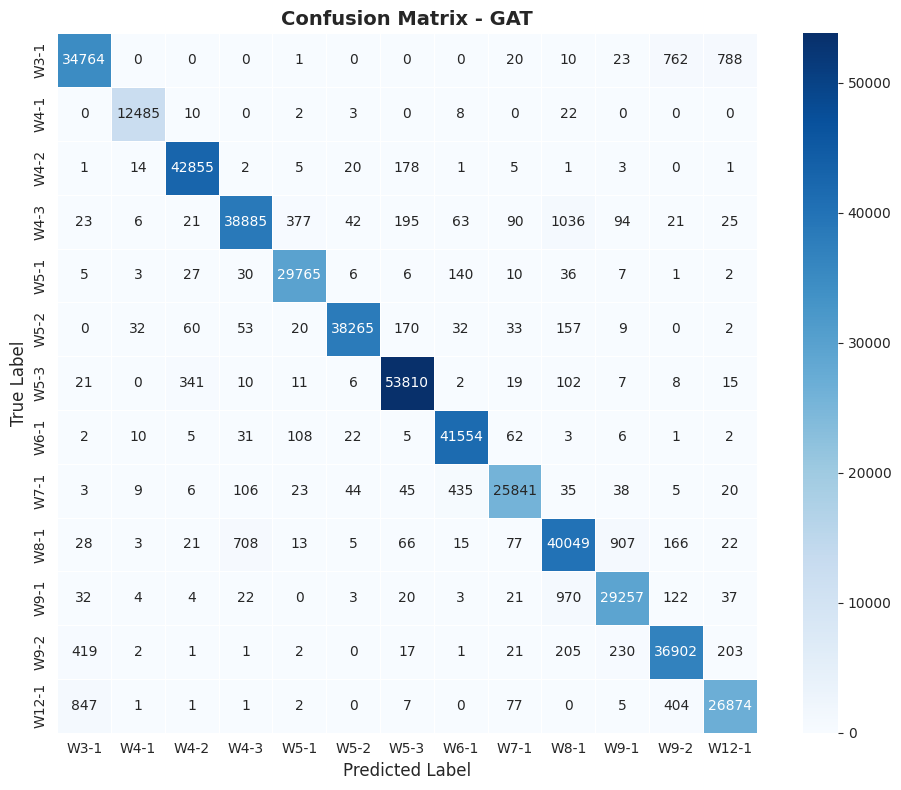

In [48]:
# Plot it
# Get the unique week stages from your data and use them as class names
class_names = adata.obs['week_stage'].unique()
plot_confusion_matrix(true_labels, predictions, class_names=class_names)

In [49]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [53]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_multiclass_roc(gat_model, graph_data, true_labels, class_names=None):
    # Evaluate GAT model
    gat_model.eval() # Puts the model in evaluation mode (disables dropout, etc.).
    with torch.no_grad(): # Disables gradient tracking for faster inference.
        out = gat_model(graph_data) # Runs the model on your full graph data to get raw log-probabilities (log-softmax outputs)
        probs = torch.exp(out).cpu().numpy() # Converts log-probabilities to actual probabilities and moves to NumPy for further processing.
        preds = out.argmax(dim=1).cpu().numpy() # Gets the predicted class label (highest-probability class) for each node.

    n_classes = probs.shape[1] # Determines how many classes there are (e.g., 13 for 13 stages).
    y_bin = label_binarize(true_labels, classes=np.arange(n_classes)) #Converts class labels into one-hot encoded format (needed for ROC curves).

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {} #Initializes dictionaries to store false positive rate, true positive rate, and AUC per class.
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i]) # Loops through each class, computes the ROC curve and area under the curve (AUC).

    # Plot setup
    plt.figure(figsize=(6, 6)) # Sets up the plot size.
    colors = cycle([
        'aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
        'purple', 'brown', 'olive', 'gold', 'black', 'pink', 'slategray'
    ]) # Prepares a set of repeating colors for different class curves

    for i, color in zip(range(n_classes), colors):
        label = class_names[i] if class_names is not None else f"Class {i}"
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{label} (AUC = {roc_auc[i]:.2f})') # Loops over each class and plots its ROC curve with label and AUC

    plt.plot([0, 1], [0, 1], 'k--', lw=0.5) # Adds the diagonal line for reference (random guessing line).
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('GAT Model ROC Curve (Multiclass)', fontsize=14, weight='bold') # Sets axis labels and title.
    plt.legend(loc='lower right', fontsize=10) # Adds legend, grid, and displays the finalized plot.
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


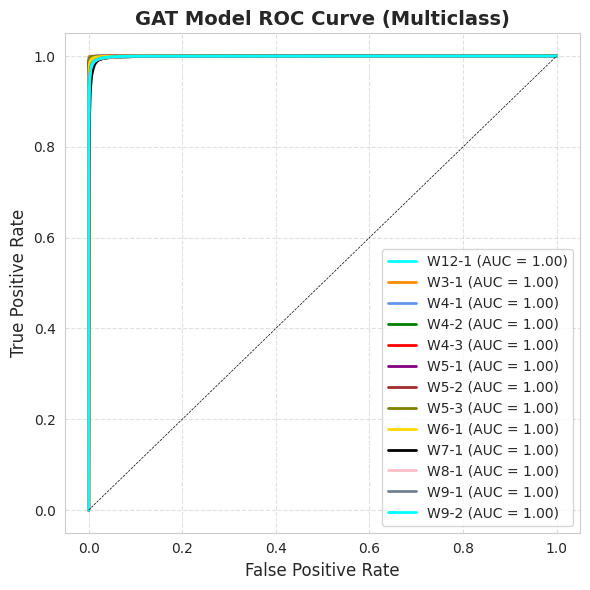

In [52]:
# Use class names from LabelEncoder if available
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
encoder = LabelEncoder() # Creates a new instance of LabelEncoder.
encoder.fit(adata.obs['week_stage']) # Fits the encoder on your original string labels (e.g. 'week_stage'), learning their unique class names and encoding.
class_names = encoder.classes_ # Retrieves the original class names in the order they were encoded — used for labeling the ROC curves properly.
true_labels = adata.obs['week_stage_encoded'].values # Extracts the numeric labels corresponding to each sample (e.g., 0–12 for 13 developmental stages).

plot_multiclass_roc(gat_model, gene_graph_data, true_labels, class_names=class_names)
# Calls your ROC plotting function with the model, graph data, true labels, and human-readable class names.


Top 50 Most Important Genes:
              Gene  Importance
92            CD53    1.000000
26            C1QC    0.946847
899          GPR34    0.724857
130          CKS1B    0.681306
6             ENO1    0.654598
550          HMGB2    0.649836
457          CRMP1    0.623130
1988        MT-ND1    0.616719
1165          HBG1    0.573198
402          GAP43    0.532743
825   RP11-797H7.5    0.527281
329         EEF1B2    0.499475
535           GYPB    0.463070
190           ASPM    0.460251
59          ELAVL4    0.443525
25            C1QA    0.432955
912           CDX4    0.420709
536           GYPA    0.417865
1324          KRT8    0.393275
110         MLLT11    0.358571
157            MPZ    0.357528
534           GYPE    0.353286
28             ID3    0.340387
639          PTTG1    0.328726
879       TMEM176B    0.322592
295           TBR1    0.316709
803       HOXA-AS3    0.310356
1519      KIAA0101    0.304307
155         FCER1G    0.295418
377         CX3CR1    0.294675
1993      

<ipython-input-56-1d960cd5323f>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


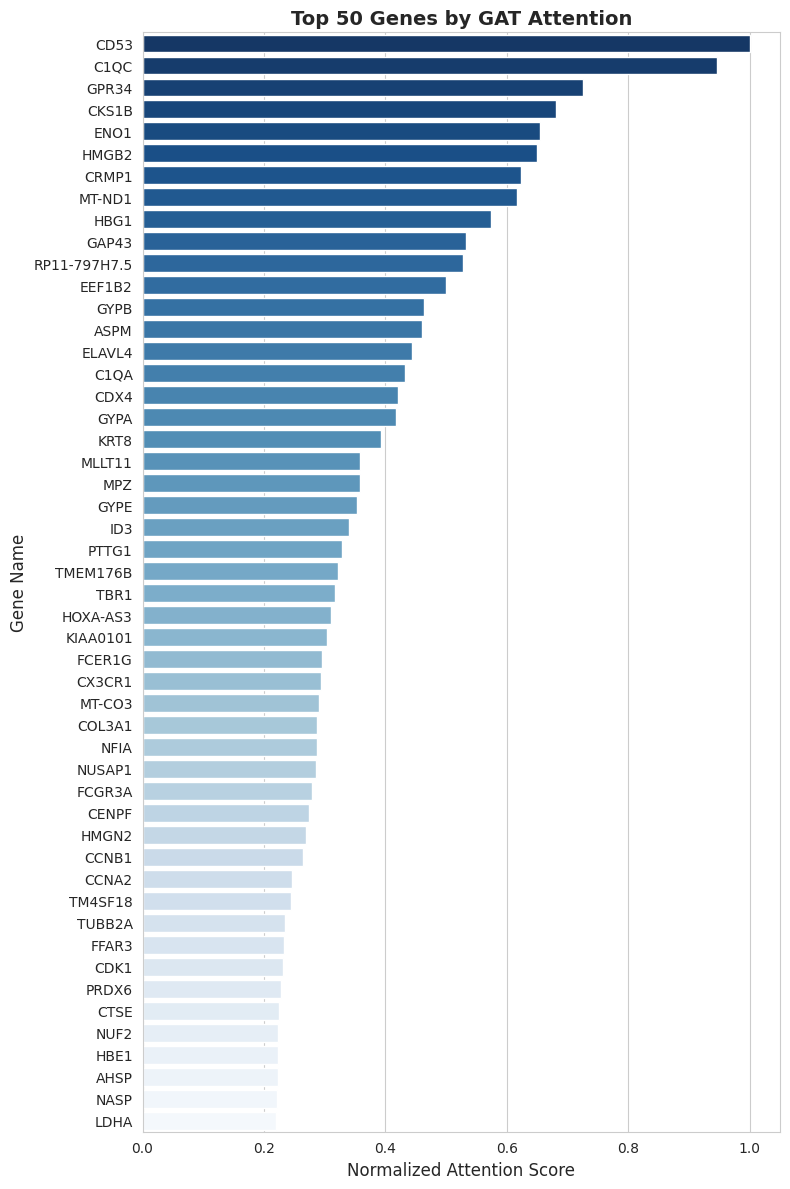

In [56]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to extract attention weights from GAT
def extract_attention_weights(model, data):
    model.eval() # switches the model to evaluation mode, which disables dropout and freezes batch normalization layers
    with torch.no_grad(): # Disables gradient calculation to save memory.
        _, (edge_index, attention_weights) = model.conv1(data.x, data.edge_index, return_attention_weights=True) # Passes data through the first GAT laye
# edge_index: the graph structure , # attention_weights: attention values for each edge
    return edge_index.cpu().numpy(), attention_weights.cpu().numpy() # Converts tensors to NumPy arrays and returns them

# Extract attention weights
edge_index, attention_weights = extract_attention_weights(gat_model, gene_graph_data) # Calls the above function to get edge-wise attention scores.

# If multi-head attention, average over heads
if attention_weights.ndim == 2:  # Shape (num_edges, num_heads)
# If multiple attention heads, average them across heads to get a single score per edge.
    attention_weights = np.mean(attention_weights, axis=1)  # Take mean across heads

# Aggregate attention scores per **gene** (not per node)
# Initializes a list of gene names and an array of zeros for storing total attention per gene.
gene_names = list(adata.var_names)  # 2000 genes
gene_importance = np.zeros(len(gene_names))

# Map node indices to genes
node_to_gene_map = adata.var_names.to_list()  # Ensures node indices can be mapped correctly to gene names.

for i in range(edge_index.shape[1]): # For each edge, adds the attention score to the source node's total attention.
    source = edge_index[0, i]  # Source node index
    if source < len(gene_names):  # Ensure mapping only within gene list
        weight = attention_weights[i]
        gene_importance[source] += weight  # Sum attention scores per gene

# Normalize importance scores
gene_importance /= np.max(gene_importance)  # Normalize to range [0, 1]

#Stores gene names and their importance scores in a DataFrame and sorts them by score (descending).
gene_importance_df = pd.DataFrame({"Gene": gene_names, "Importance": gene_importance})
gene_importance_df = gene_importance_df.sort_values(by="Importance", ascending=False)

# Display top 50 most important genes
print("Top 50 Most Important Genes:")
print(gene_importance_df.head(50))
import seaborn as sns

plt.figure(figsize=(8, 12))
sns.barplot(
    x="Importance", y="Gene",
    data=gene_importance_df.head(50),
    palette="Blues_r"
)
plt.title("Top 50 Genes by GAT Attention", fontsize=14, weight='bold')
plt.xlabel("Normalized Attention Score", fontsize=12)
plt.ylabel("Gene Name", fontsize=12)
plt.tight_layout()
plt.show()


the normalized attention score represents the relative importance the model assigns to each gene based on how much it contributes to the final prediction. These scores are computed by aggregating attention weights across graph edges and then rescaling them between 0 and 1. A score of 1 means that gene was the most influential among all, while a score closer to 0 indicates lesser influence.

In [ ]:
import pandas as pd
import torch

# Get unique weeks
unique_weeks = adata.obs['week_stage'].unique()

# Dictionary to store results
top_genes_per_week = {}

# Iterate through each week
for week in unique_weeks:
    print(f"Processing Week: {week}")

    # Subset data for the current week
    week_mask = adata.obs['week_stage'] == week

    # Create a new Data object with the subsetted data and original graph structure
    week_data = Data(x=gene_graph_data.x[week_mask], # week_mask is a boolean or index tensor used to filter only the nodes
                     edge_index=gene_graph_data.edge_index,
                     edge_attr=gene_graph_data.edge_attr)
    # it creates a subgraph for a specific developmental week. The x parameter selects node features using week_mask, so only relevant genes are included

    # Get attention scores for this week
    with torch.no_grad():
        gat_output = gat_model(week_data)  # Runs the GAT model on the week's subgraph to get predictions

        # Get attention weights from the first GATConv layer Passes data through the first GAT layer and retrieves:
        _, (edge_index, attention_weights) = gat_model.conv1(week_data.x, week_data.edge_index, return_attention_weights=True)
        attention_weights = attention_weights.cpu().numpy()
        # edge_index: the graph edges and attention_weights: learned attention for each edge

        # If multi-head attention, average over heads
        if attention_weights.ndim == 2:  # Shape (num_edges, num_heads)
            attention_weights = np.mean(attention_weights, axis=1)  # Take mean across heads

        # Aggregate attention scores per gene
        gene_importance = np.zeros(len(adata.var_names))
        for i in range(edge_index.shape[1]):
            source = edge_index[0, i].item()  # Get source node index as an integer
            if source < len(adata.var_names):
                gene_importance[source] += attention_weights[i]

        # Normalize importance scores
        gene_importance /= np.max(gene_importance) if np.max(gene_importance) != 0 else 1  # Avoid division by zero


    # Create DataFrame of genes and importance
    gene_importance_df = pd.DataFrame({
        "Gene": adata.var_names,
        "Importance": gene_importance
    })

    # Sort and select top 20
    gene_importance_df = gene_importance_df.sort_values(by="Importance", ascending=False).head(20)

    # Store results
    top_genes_per_week[week] = gene_importance_df

# Display results
for week, df in top_genes_per_week.items():
    print(f"\nTop 20 Genes for Week {week}")
    print(df)

Processing Week: W3-1


<ipython-input-43-ac1088f67c33>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  week_data = Data(x=gene_graph_data.x[week_mask],


Processing Week: W4-1
Processing Week: W4-2
Processing Week: W4-3
Processing Week: W5-1
Processing Week: W5-2
Processing Week: W5-3
Processing Week: W6-1
Processing Week: W7-1
Processing Week: W8-1
Processing Week: W9-1
Processing Week: W9-2
Processing Week: W12-1

Top 20 Genes for Week W3-1
              Gene  Importance
92            CD53    1.000000
130          CKS1B    0.986083
535           GYPB    0.884521
6             ENO1    0.877645
26            C1QC    0.760307
457          CRMP1    0.553974
155         FCER1G    0.536126
329         EEF1B2    0.516959
1165          HBG1    0.490177
377         CX3CR1    0.470634
899          GPR34    0.469192
1988        MT-ND1    0.468286
25            C1QA    0.468256
402          GAP43    0.444013
1990        MT-CO2    0.441505
825   RP11-797H7.5    0.429092
59          ELAVL4    0.414567
190           ASPM    0.397057
157            MPZ    0.388515
657         TUBB2A    0.385442

Top 20 Genes for Week W4-1
              Gene  Importan

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_genes_bar(top_genes_per_week):
    sns.set(style="whitegrid")

    for week, df in top_genes_per_week.items():
        df_sorted = df.sort_values(by="Importance", ascending=False)  # Sort largest first

        plt.figure(figsize=(10, 6))
        sns.barplot(
            x="Importance",
            y="Gene",
            data=df_sorted,  # Use sorted DataFrame
            palette="Blues_r"
        )
        plt.xlabel("Normalized Attention Score", fontsize=12)
        plt.ylabel("Gene Name", fontsize=12)
        plt.title(f"Top 20 Genes in {week} Based on GAT Attention Scores", fontsize=14, weight='bold')
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


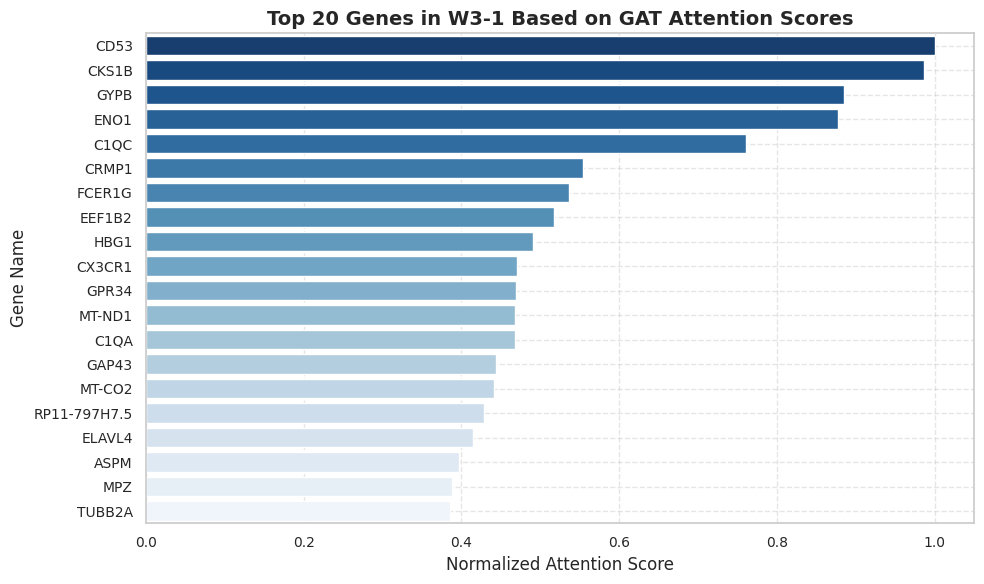

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


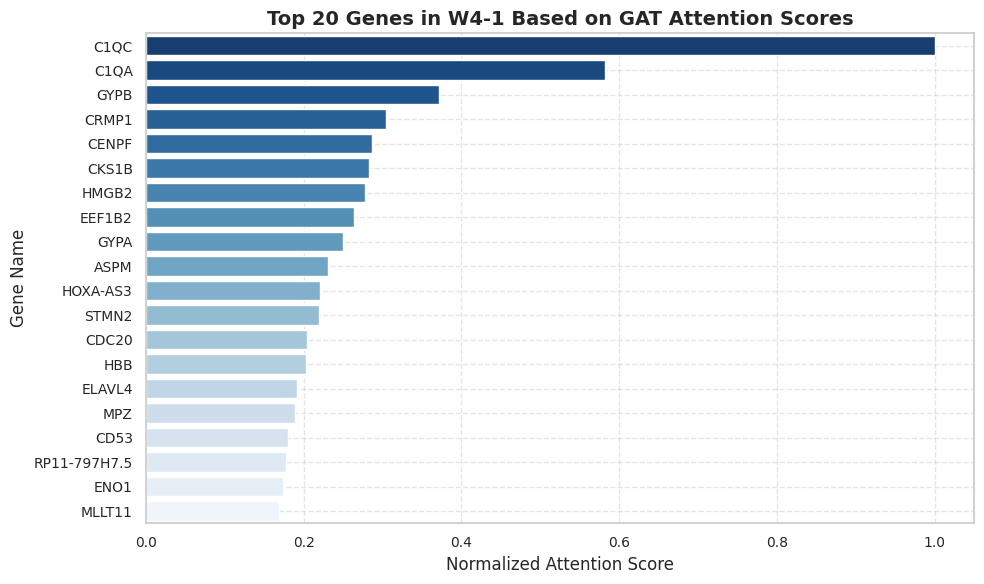

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


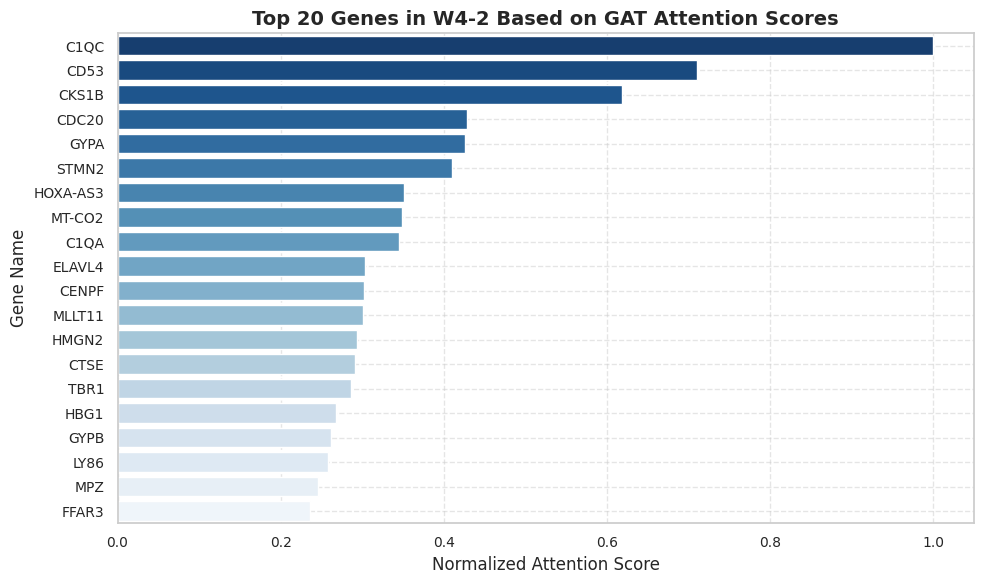

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


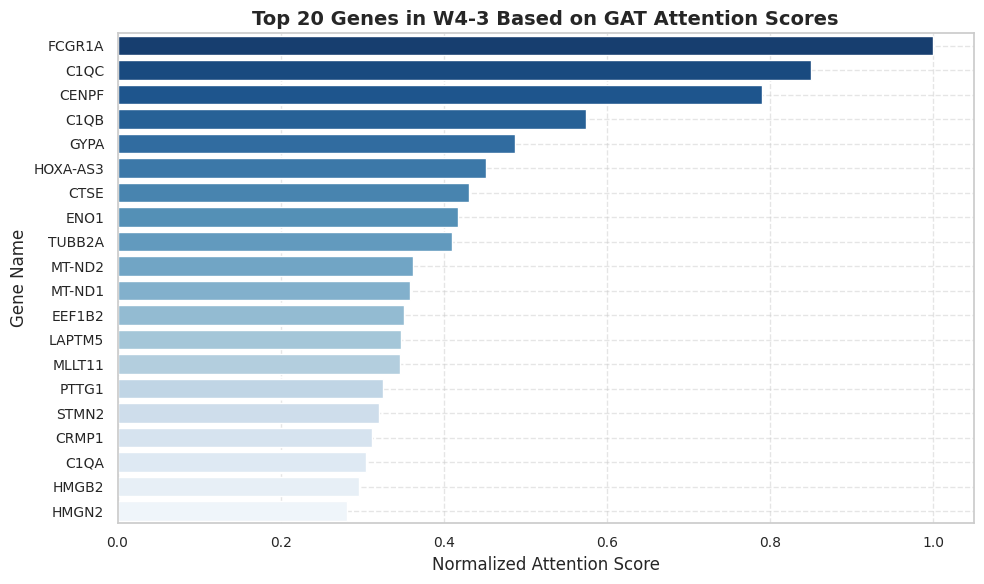

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


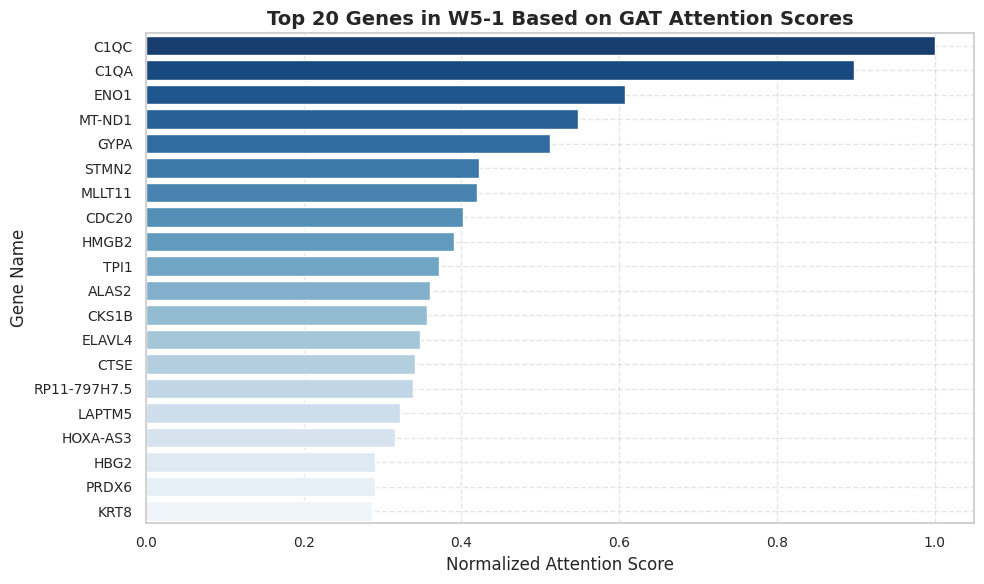

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


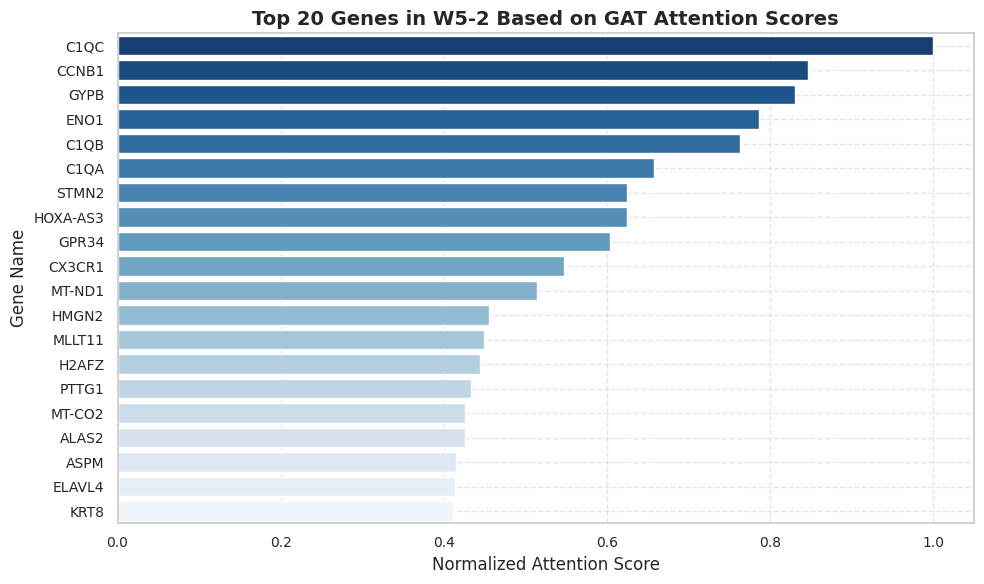

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


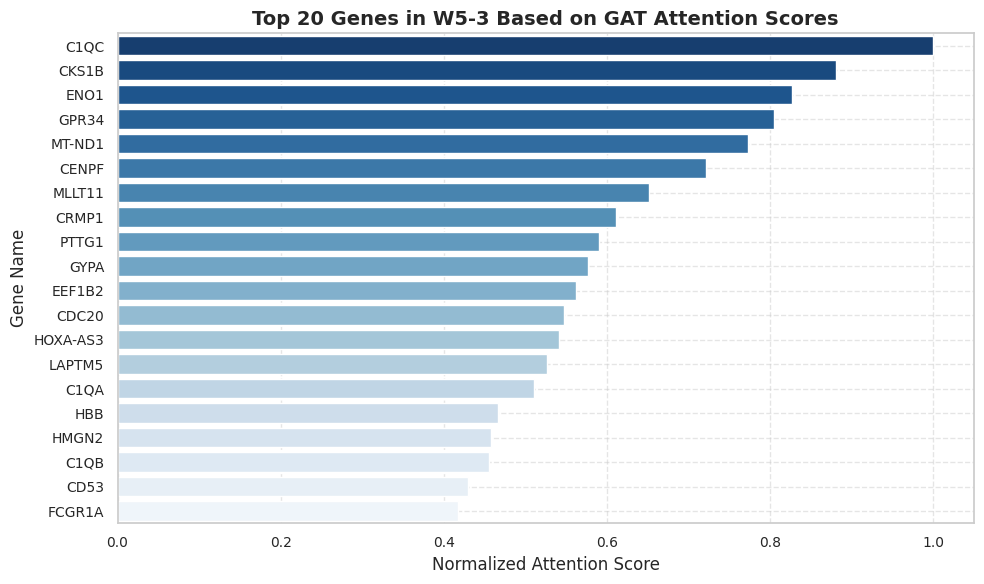

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


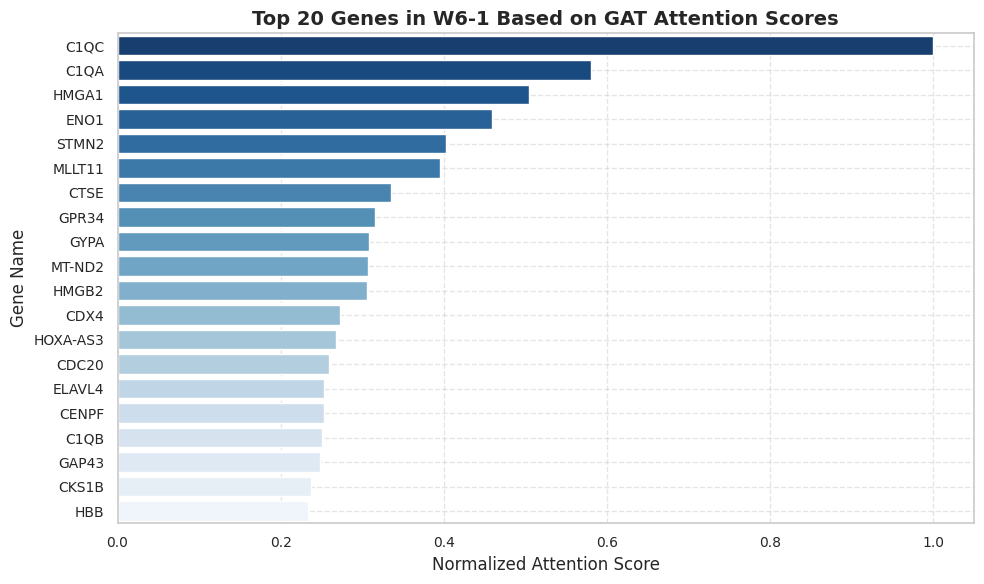

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


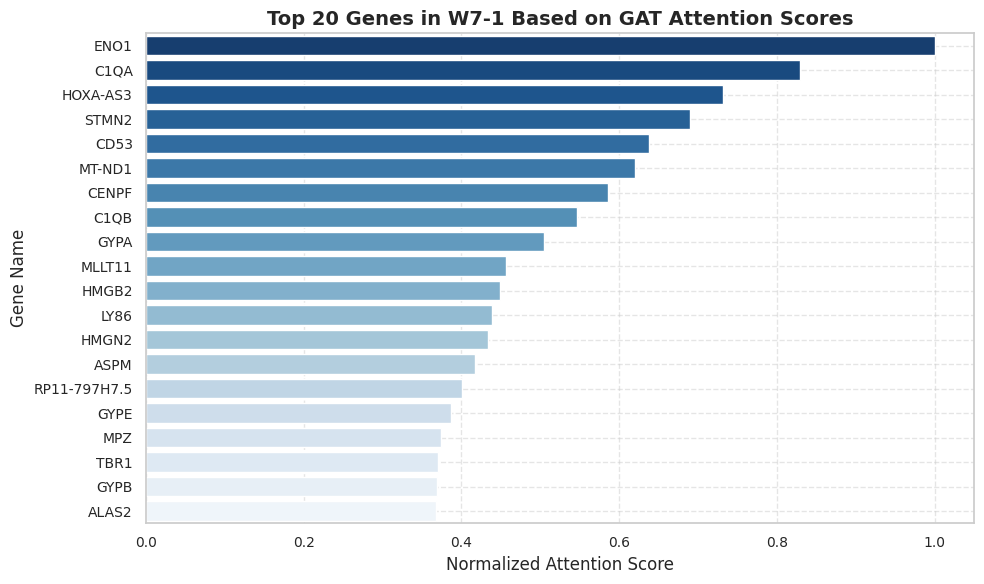

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


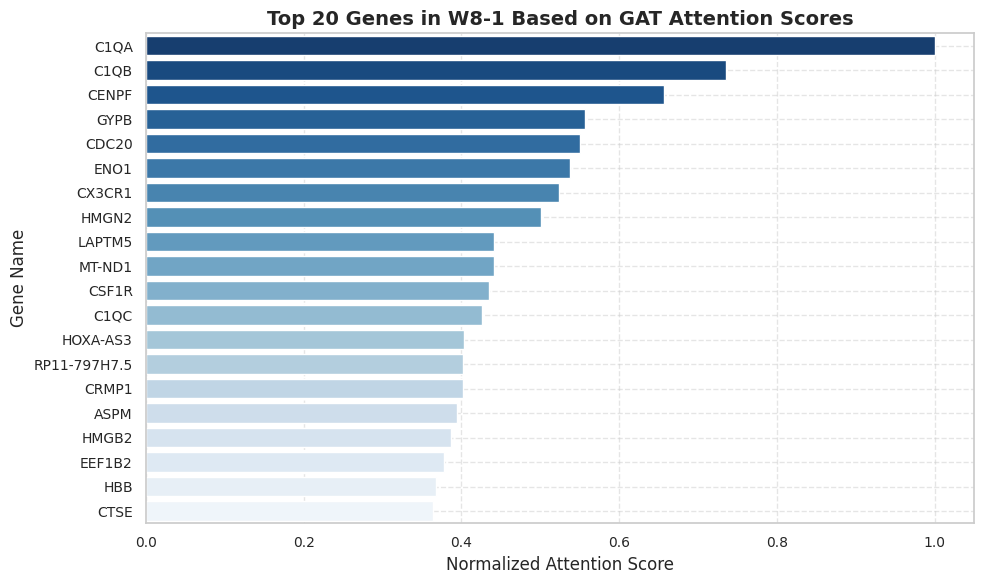

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


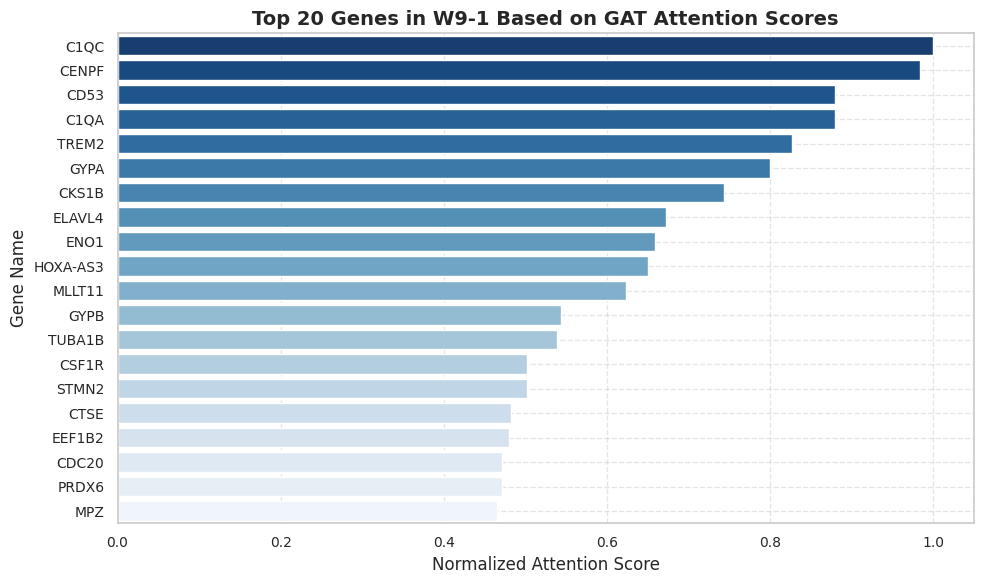

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


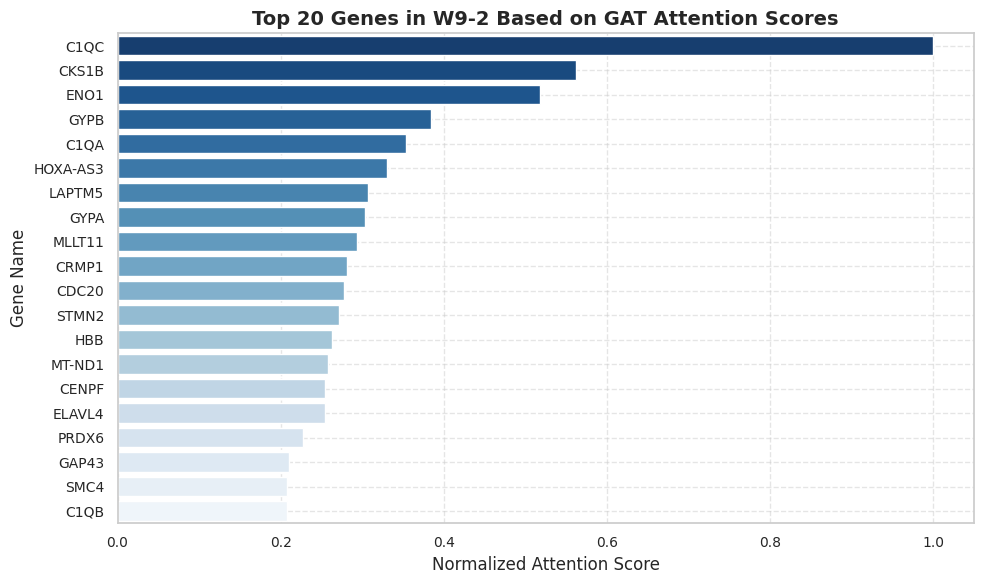

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


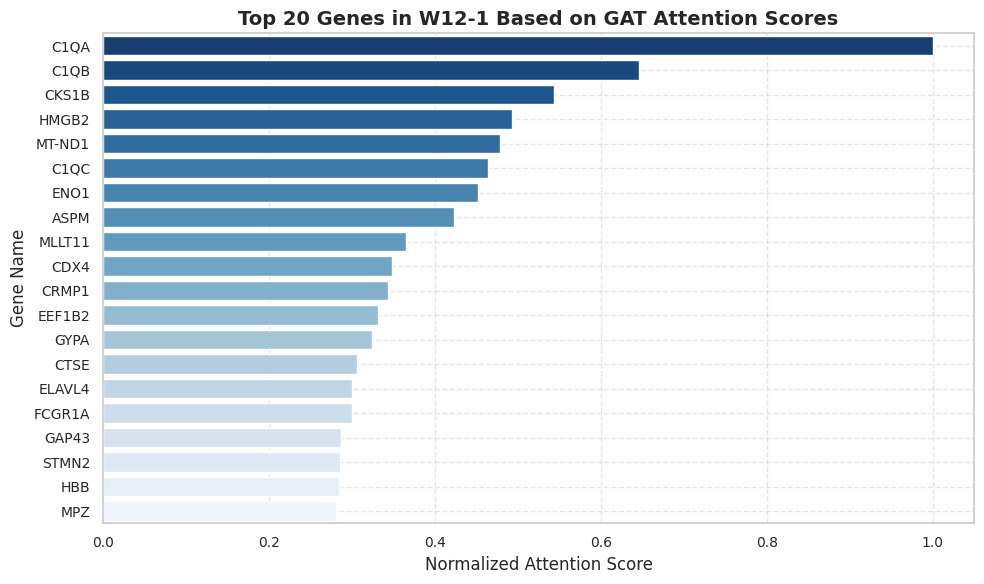

In [ ]:
plot_top_genes_bar(top_genes_per_week)


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


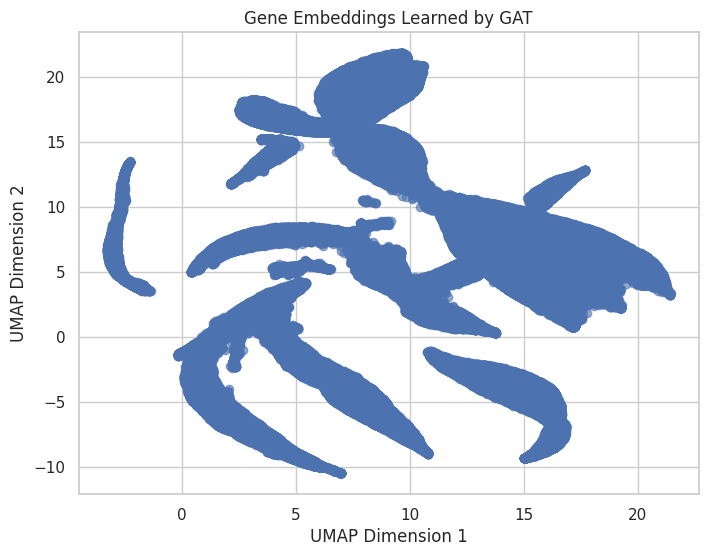

In [ ]:
# UMAP is used for dimensionality reduction and visualization (faster than tsne)
from umap import UMAP
import matplotlib.pyplot as plt
import torch

# Get embeddings from the output of the GAT model
gat_model.eval()  # Set the model to evaluation mode (disables dropout and batch norm updates)
with torch.no_grad():
    gat_output = gat_model(gene_graph_data)  #Runs the GAT model on your full gene graph to get node embeddings, without calculating gradients.

# gat_output contains the node embeddings, usually in the shape (num_nodes, embedding_dim)
gat_embeddings = gat_output.cpu().detach().numpy() #Converts the output from a PyTorch tensor to a NumPy array for UMAP

# Apply UMAP for dimensionality reduction
umap = UMAP(n_components=2, random_state=42)
embeddings_2d = umap.fit_transform(gat_embeddings)

# Scatter plot of gene embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("Gene Embeddings Learned by GAT")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_embeddings_colored_by_stage(embeddings_2d, cluster_labels, stage_names=None):
    sns.set(style="whitegrid")

    unique_clusters = cluster_labels.unique()
    num_clusters = len(unique_clusters)
    palette = sns.color_palette("husl", num_clusters)
    cluster_color_map = dict(zip(unique_clusters, palette))

    plt.figure(figsize=(8, 6))

    for cluster in unique_clusters:
        cluster_indices = cluster_labels == cluster
        plt.scatter(
            embeddings_2d[cluster_indices, 0],
            embeddings_2d[cluster_indices, 1],
            color=cluster_color_map[cluster],
            label=stage_names.get(cluster, cluster) if stage_names else cluster,
            s=20, alpha=0.7
        )

    plt.xlabel("UMAP Dimension 1", fontsize=12)
    plt.ylabel("UMAP Dimension 2", fontsize=12)
    plt.title("Gene Embeddings Learned by GAT (Colored by Week Stage)", fontsize=14, weight='bold')
    plt.legend(title="Stage", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


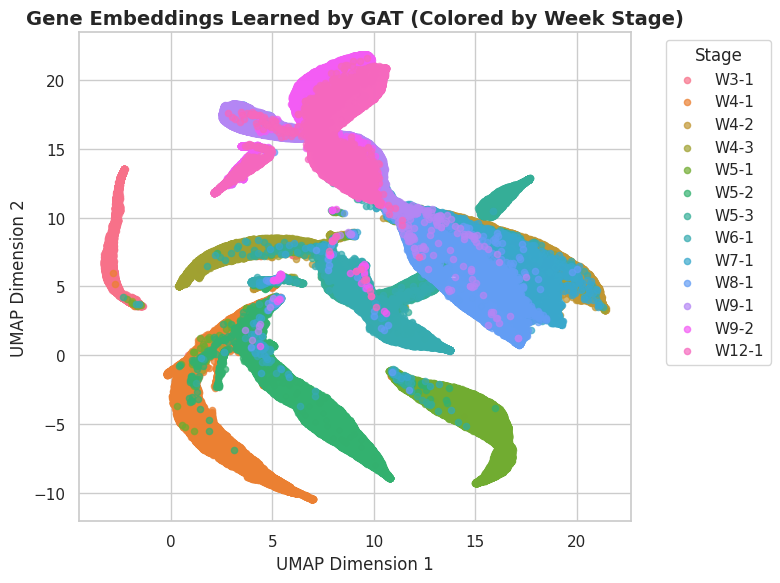

In [ ]:
# If you have stage_names mapping
plot_embeddings_colored_by_stage(embeddings_2d, adata.obs['week_stage'])



Each color represents a developmental week. The visible clustering demonstrates that GAT has successfully captured week-specific gene expression patterns, indicating strong biological relevance in the learned representations.

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Prepare data
X = adata.X # Uses the gene expression matrix (cells × genes) as input features.
y = LabelEncoder().fit_transform(adata.obs["week_stage"]) # Converts the categorical developmental stage labels (e.g., "W3-1") into numeric format for classification.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42) # Initializes the Random Forest with 100 trees.
# Splits the data into training (80%) and test (20%) sets with a fixed seed for reproducibility.
rf_model.fit(X_train, y_train) # Trains the model on the training data.

# Predict
y_pred_rf = rf_model.predict(X_test) # Uses the trained model to predict developmental stages for the test set.

# Evaluation
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 98.16%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      7333
           1       1.00      0.99      1.00      2469
           2       0.99      1.00      0.99      8635
           3       0.98      0.97      0.97      8226
           4       0.98      0.99      0.99      5900
           5       1.00      0.99      1.00      7758
           6       1.00      0.99      1.00     10850
           7       0.99      1.00      0.99      8408
           8       0.99      0.98      0.99      5324
           9       0.95      0.98      0.96      8397
          10       0.98      0.94      0.96      6057
          11       0.98      0.99      0.98      7673
          12       0.97      0.94      0.95      5631

    accuracy                           0.98     92661
   macro avg       0.98      0.98      0.98     92661
weighted avg       0.98      0.98      0.98     92661



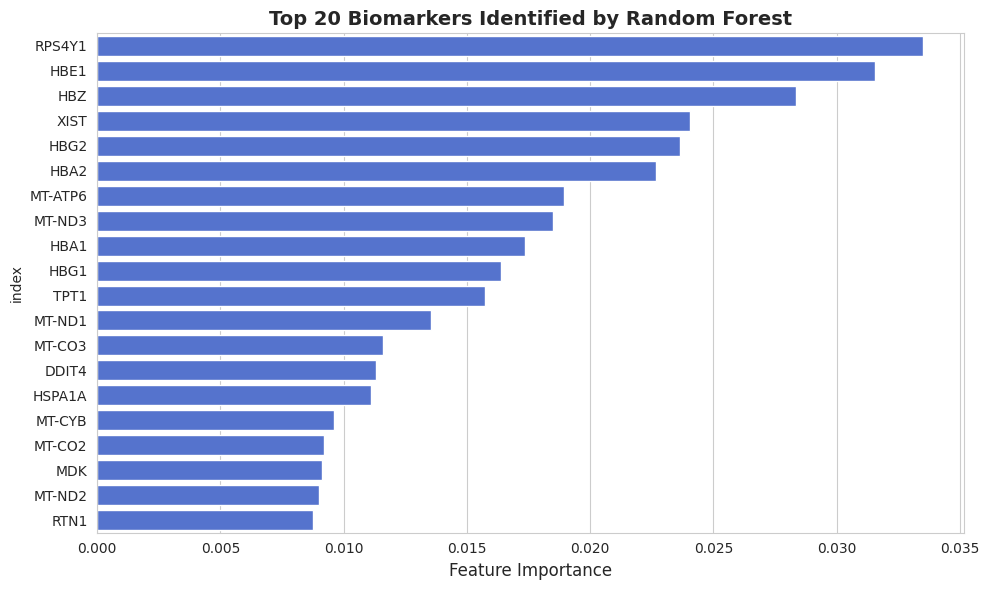

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance
rf_importance = pd.Series(rf_model.feature_importances_, index=adata.var_names).nlargest(20)
# Extracts feature importance scores from the trained Random Forest.
#Maps them to gene names using adata.var_names

plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importance.values, y=rf_importance.index, color="royalblue")  # Use a single color
plt.xlabel("Feature Importance", fontsize=12)
plt.title("Top 20 Biomarkers Identified by Random Forest", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(true_labels, predictions, class_names=None, normalize=False, title='Confusion Matrix - Random Forest'):
  # normalize: If True, shows proportions instead of raw counts — useful for imbalanced data.
    cm = confusion_matrix(true_labels, predictions, normalize='true' if normalize else None)
    acc = accuracy_score(true_labels, predictions) # Computes the overall accuracy of the predictions.

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', linewidths=0.5, square=True,
                xticklabels=class_names, yticklabels=class_names)
    # annot=True shows numbers in each cell. Format is decimal if normalized, otherwise integers.

    plt.xlabel("Predicted Week Stage", fontsize=12)
    plt.ylabel("True Week Stage", fontsize=12)
    # Setting the title using the 'title' parameter
    plt.title(title, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()


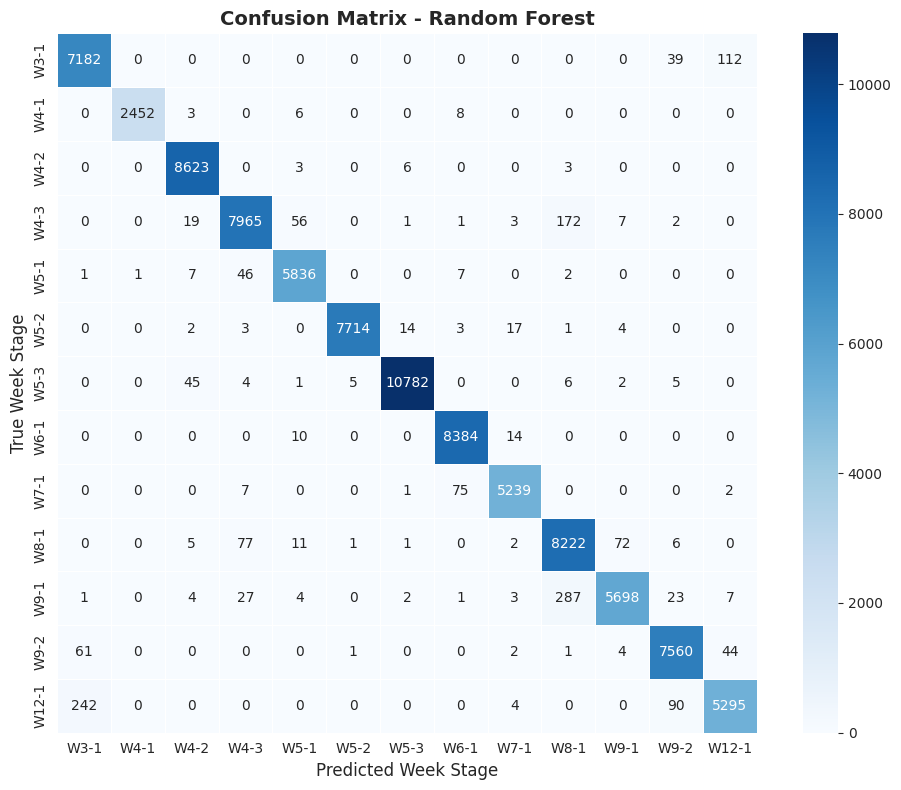

In [60]:
class_names = adata.obs['week_stage'].unique()
plot_confusion_matrix(y_test, y_pred_rf, class_names=class_names, normalize=False)


In [61]:
from sklearn.metrics import classification_report

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Generate classification report
print(" Classification Report — Random Forest:\n")
print(classification_report(y_test, y_pred_rf, zero_division=0))


📊 Classification Report — Random Forest:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7333
           1       1.00      0.99      1.00      2469
           2       0.99      1.00      0.99      8635
           3       0.98      0.97      0.97      8226
           4       0.98      0.99      0.99      5900
           5       1.00      0.99      1.00      7758
           6       1.00      0.99      1.00     10850
           7       0.99      1.00      0.99      8408
           8       0.99      0.98      0.99      5324
           9       0.95      0.98      0.96      8397
          10       0.98      0.94      0.96      6057
          11       0.98      0.99      0.98      7673
          12       0.97      0.94      0.95      5631

    accuracy                           0.98     92661
   macro avg       0.98      0.98      0.98     92661
weighted avg       0.98      0.98      0.98     92661



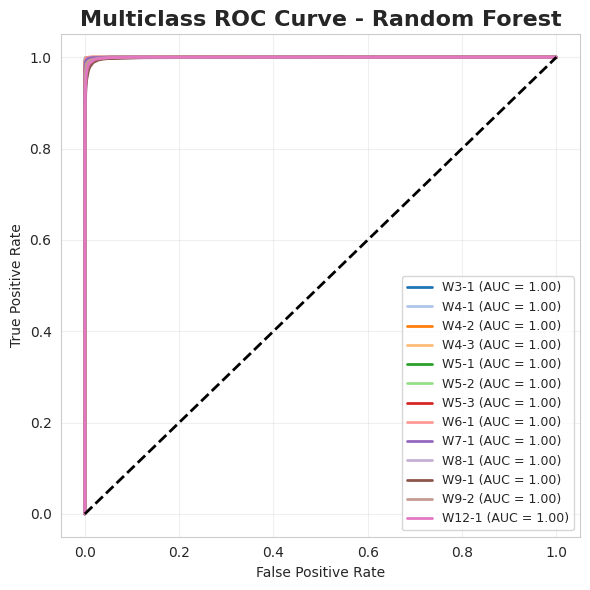

In [62]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

#y_true: true class labels, y_score: predicted probabilities, n_classes: number of classes, class_names: optional human-readable class labe
def plot_multiclass_roc(y_true, y_score, n_classes, class_names=None):
    # Binarize labels
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    # Converts class labels to one-hot encoded format for ROC computation.

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i]) # Computes the False Positive Rate and True Positive Rate
        roc_auc[i] = auc(fpr[i], tpr[i]) # Calculates the Area Under the Curve (AUC)

    # Plot
    plt.figure(figsize=(6, 6))
    colors = cycle(plt.cm.tab20.colors)  # More colorful and automatic
    for i, color in zip(range(n_classes), colors):
        label_name = class_names[i] if class_names is not None else f"Class {i}" # Uses the actual class name (like "PCW3") if available else start with 0
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{label_name} (AUC = {roc_auc[i]:.2f})') # Plots the ROC curve for each class, with label and AUC.

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve - Random Forest', fontsize=16, weight='bold')
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Usage
n_classes = rf_model.n_classes_ # gets number of classes from the RF model
rf_probs = rf_model.predict_proba(X_test) # Gets the predicted class probabilities for the test set.

week_stage_names = adata.obs['week_stage'].unique() # Extracts the unique developmental stage names from the dataset to use as labels on the ROC curve plot.

plot_multiclass_roc(y_test, rf_probs, n_classes, class_names=week_stage_names)


In [63]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.4 MB/s eta 0:00:00


In [64]:
import xgboost as xgb

<ipython-input-65-45658fb2df2d>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=df, palette=palette)


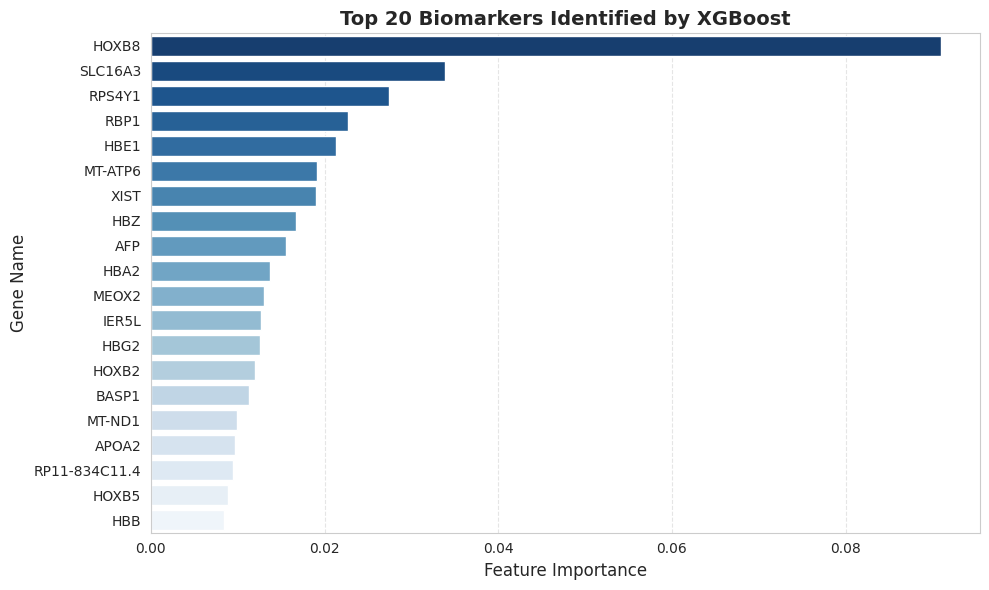

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    #'multi:softmax' means the model will perform multi-class classification and directly output predicted class labels (not probabilities).
    num_class=len(np.unique(y)), # Sets the number of classes based on the unique labels in y
    eval_metric='mlogloss',
    #  Defines the evaluation metric used during training to monitor performance.
    #'mlogloss' (multiclass log-loss) penalizes incorrect predictions more heavily when the model is confident — great for probabilistic classification.

    n_estimators=200, # More trees can improve accuracy but increase training time and overfitting risk.
    learning_rate=0.05, # A lower value (like 0.05) leads to slower, more stable learning (often combined with a higher number of trees).
    max_depth=6, # The tree can split up to 6 times from root to leaf.
    subsample=0.8, # Uses only 80% of the training data per boosting round.
    colsample_bytree=0.8, # Uses only 80% of the features (genes) when building each tree.
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Extract top 20 important genes
importance_df = pd.DataFrame({
    'Gene': adata.var_names,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(20) # Each gene name from adata.var_names to its feature importance score from the trained xgb_model
# feature_importances_ shows how much each gene (feature) contributed to the model’s decisions.

# Reverse importance for color mapping (high = dark)
importance_df = importance_df.sort_values('Importance', ascending=True)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_top_features(importances, feature_names, top_n=20, title="Top Features", palette="Blues_r"):
    # Prepare DataFrame
    df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=df, palette=palette)
    plt.xlabel("Feature Importance", fontsize=12)
    plt.ylabel("Gene Name", fontsize=12)
    plt.title(title, fontsize=14, weight="bold")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_top_features(
    importances=xgb_model.feature_importances_,
    feature_names=adata.var_names,
    top_n=20,
    title="Top 20 Biomarkers Identified by XGBoost"
)



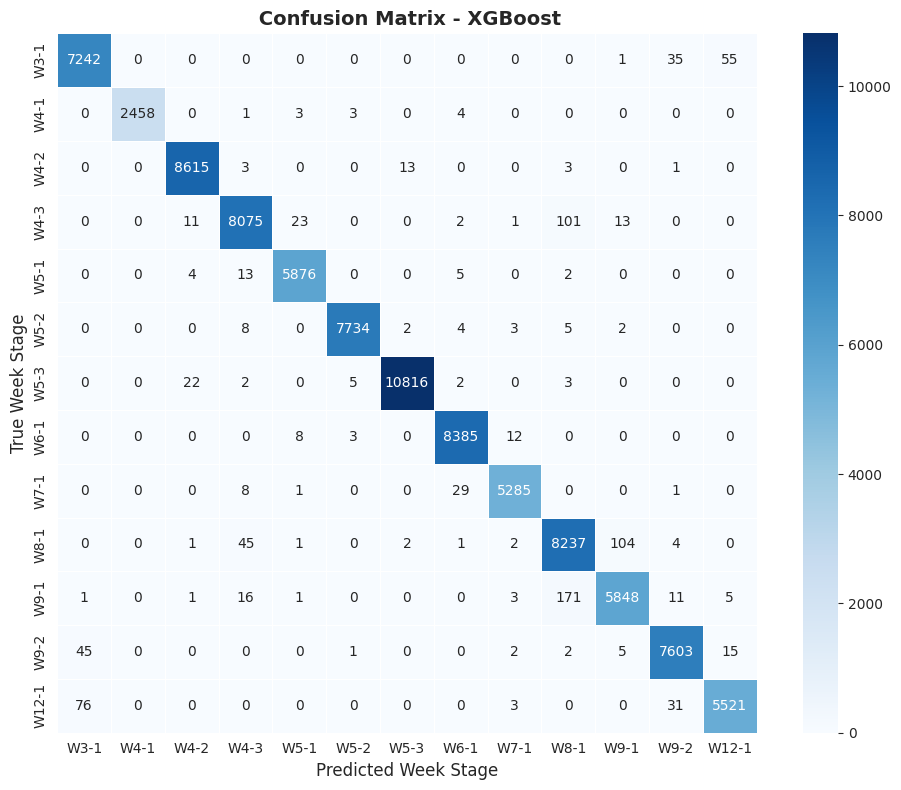

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(true_labels, predictions, class_names=None, normalize=False, title_model="Model"):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions, normalize='true' if normalize else None)
    acc = accuracy_score(true_labels, predictions)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', linewidths=0.5, square=True,
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted Week Stage", fontsize=12)
    plt.ylabel("True Week Stage", fontsize=12)

    # Setting the title using f-string formatting
    title = f"{'Normalized' if normalize else ''} Confusion Matrix - {title_model}"
    plt.title(title, fontsize=14, weight='bold')  # Add title to the plot

    plt.tight_layout()
    plt.show()

# Uses the trained XGBoost model to predict class labels for the test set (X_test).
y_pred_xgb = xgb_model.predict(X_test)
class_names = adata.obs['week_stage'].cat.categories if hasattr(adata.obs['week_stage'], 'cat') else np.unique(adata.obs['week_stage'])

plot_confusion_matrix(y_test, y_pred_xgb, class_names=class_names, normalize=False, title_model="XGBoost")


In [67]:
# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Generate classification report
print("📊 Classification Report — XGBoost:\n")
print(classification_report(y_test, y_pred_xgb, zero_division=0))

📊 Classification Report — XGBoost:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7333
           1       1.00      1.00      1.00      2469
           2       1.00      1.00      1.00      8635
           3       0.99      0.98      0.98      8226
           4       0.99      1.00      0.99      5900
           5       1.00      1.00      1.00      7758
           6       1.00      1.00      1.00     10850
           7       0.99      1.00      1.00      8408
           8       1.00      0.99      0.99      5324
           9       0.97      0.98      0.97      8397
          10       0.98      0.97      0.97      6057
          11       0.99      0.99      0.99      7673
          12       0.99      0.98      0.98      5631

    accuracy                           0.99     92661
   macro avg       0.99      0.99      0.99     92661
weighted avg       0.99      0.99      0.99     92661



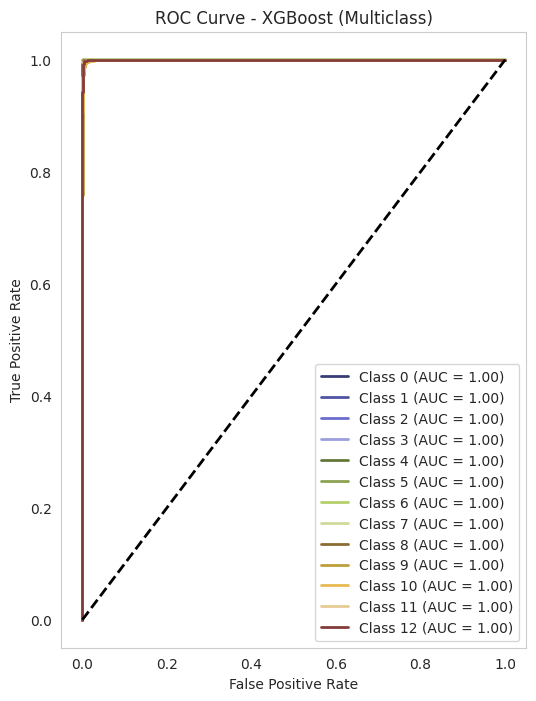

In [72]:
# Predict class probabilities with XGBoost
xgb_probs = xgb_model.predict_proba(X_test)

# Binarize y_test again if needed
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
# Converts multiclass y_test (e.g., 0–12) into a binary matrix (one-hot encoded).



# Compute ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], xgb_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Computes FPR and TPR using true labels (y_test_bin[:, i]) and predicted probabilities (xgb_probs[:, i]).

# Plot all ROC curves
plt.figure(figsize=(6, 8))
colors = cycle(plt.cm.tab20b.colors)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Plots a diagonal line (random guessing baseline).
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Multiclass)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [69]:
!pip install matplotlib-venn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [76]:
top_n = 200  # keep consistent for all models

# Recreate RF importance properly
rf_importance = pd.Series(rf_model.feature_importances_, index=adata.var_names).sort_values(ascending=False)
top_rf_genes = set(rf_importance.head(top_n).index)

# XGB already done
xgb_importance = pd.Series(xgb_model.feature_importances_, index=adata.var_names).sort_values(ascending=False)
top_xgb_genes = set(xgb_importance.head(top_n).index)

# GAT attention-based importance
# Calculate mean attention scores per gene
edge_index, attention_weights = extract_attention_weights(gat_model, gene_graph_data) # Extracts attention scores from your trained GAT model.
mean_attention = np.zeros(len(adata.var_names)) #Initializes an array to hold the aggregated attention score for each gene (one per node).
for i in range(edge_index.shape[1]): # Loops through each edge in the graph.
    source = edge_index[0, i] # extracts the source node index of edge i
    if source < len(adata.var_names): #Safeguard to ensure source is a valid index in your gene list.

        # Take the mean of attention weights if it's a multi-head attention
        mean_attention[source] += np.mean(attention_weights[i])
mean_attention /= np.max(mean_attention)  #Normalizes the attention scores so they are in the range 0–1.

# Create and sort biomarkers based on mean attention
gat_biomarkers = pd.Series(mean_attention, index=adata.var_names).sort_values(ascending=False)
top_gat_genes = set(gat_biomarkers.head(top_n).index)

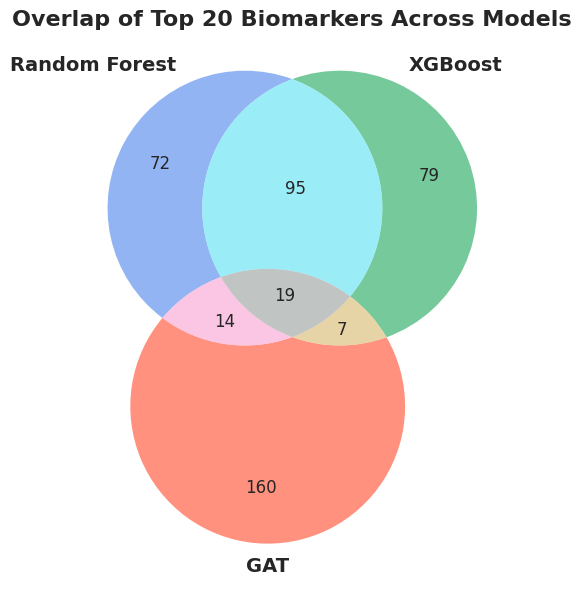


Common Biomarkers Across All 3 Models (19 genes):
- COL3A1
- ELAVL4
- ENO1
- HBB
- HBE1
- HBG1
- HMGB2
- HMGN2
- ID3
- KRT8
- MDK
- MLLT11
- MT-CO3
- MT-ND1
- NEUROD6
- NFIA
- STMN2
- TPI1
- TUBB2B


In [78]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

def plot_biomarker_overlap(top_rf_genes, top_xgb_genes, top_gat_genes, top_n=20):
    plt.figure(figsize=(6, 6))
    venn = venn3(
        (top_rf_genes, top_xgb_genes, top_gat_genes),
        set_labels=("Random Forest", "XGBoost", "GAT"),
        set_colors=('cornflowerblue', 'mediumseagreen', 'tomato'),
        alpha=0.7
    )


    for text in venn.set_labels:
        if text:
            text.set_fontsize(14)
            text.set_fontweight('bold')
    for text in venn.subset_labels:
        if text:
            text.set_fontsize(12)

    plt.title(f"Overlap of Top {top_n} Biomarkers Across Models", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

    # Print intersection (optional)
    common_genes = top_rf_genes & top_xgb_genes & top_gat_genes
    print(f"\nCommon Biomarkers Across All 3 Models ({len(common_genes)} genes):")
    if len(common_genes) > 0:
        for gene in sorted(common_genes):
            print(f"- {gene}")
    else:
        print("No common genes found.")

# ➡️ Example usage:
plot_biomarker_overlap(top_rf_genes, top_xgb_genes, top_gat_genes, top_n=20)


In [79]:
# Genes shared by all three models
common_all = top_rf_genes & top_xgb_genes & top_gat_genes

# Genes shared by RF and XGB only
common_rf_xgb = (top_rf_genes & top_xgb_genes) - common_all

# Genes shared by GAT and RF only
common_rf_gat = (top_rf_genes & top_gat_genes) - common_all

# Genes shared by GAT and XGB only
common_xgb_gat = (top_xgb_genes & top_gat_genes) - common_all

# Unique to each model
unique_rf = top_rf_genes - (top_xgb_genes | top_gat_genes)
unique_xgb = top_xgb_genes - (top_rf_genes | top_gat_genes)
unique_gat = top_gat_genes - (top_rf_genes | top_xgb_genes)


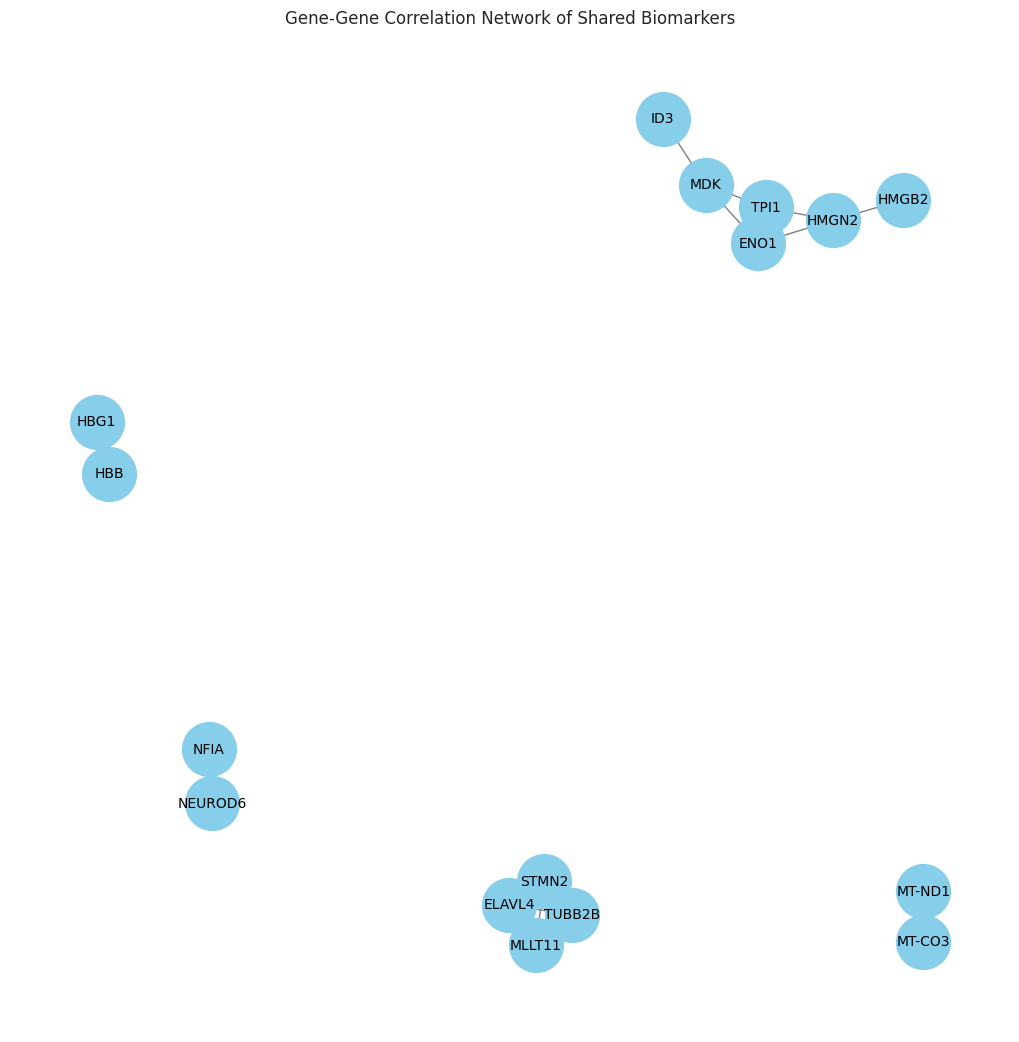

In [81]:
import networkx as nx
 # Genes shared by all three models
common_all = top_rf_genes & top_xgb_genes & top_gat_genes

# Assign the shared genes to the variable 'shared_genes'
shared_genes = list(common_all)  # Convert the set to a list

# Subset adata to shared genes
adata_shared = adata[:, shared_genes]

# Compute gene-gene correlation
gene_expr = adata_shared.X.T # Transposes the matrix to shape (genes × cells) so each row is a gene.
corr_matrix = np.corrcoef(gene_expr) # Computes the correlation matrix between all pairs of g

# Create graph from strong correlations
G = nx.Graph()
genes = shared_genes
for i in range(len(genes)):
    for j in range(i + 1, len(genes)):
        corr = corr_matrix[i, j]
        if abs(corr) > 0.6:  # Loops over gene pairs and adds an edge if the absolute correlation is strong (>|0.6|).
            G.add_edge(genes[i], genes[j], weight=corr) #The edge's weight reflects the strength of correlation.

# Plot network
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42) #d generates node positions using the spring layout
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1500, font_size=10)
# Draws the graph with labeled nodes, colored in sky blue, with gray edges and readable font.

plt.title("Gene-Gene Correlation Network of Shared Biomarkers")
plt.show()

In [83]:
#mygene is a lightweight Python client for the MyGene.info API.
!pip install mygene --quiet

It allows you to query gene annotations (e.g., gene names, symbols, functions, pathways, GO terms) quickly and easily using gene IDs or symbols.

In [84]:
import mygene
mg = mygene.MyGeneInfo()

# Query gene functions
# If not, you'll need to define it appropriately
gene_info = mg.querymany(shared_genes, scopes='symbol', fields='symbol,name,summary,disgenet', species='human')

# Assuming 'gene_info' is your list of dictionaries:
all_variables = []
for gene_data in gene_info:
    all_variables.extend(gene_data.keys())  # Add keys from each gene

# Get unique variables to avoid duplicates
unique_variables = list(set(all_variables))

print("All Variables in gene_info:")
for variable in unique_variables:
    print(variable)

INFO:biothings.client:querying 1-19 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


All Variables in gene_info:
summary
symbol
name
query
_score
_id
notfound


In [85]:
!pip install mygene --quiet

import mygene
mg = mygene.MyGeneInfo()

# Query gene functions
gene_info = mg.querymany(shared_genes, scopes='symbol', fields='symbol,name,summary,disgenet', species='human')
# Tells mygene that my input list (shared_genes) consists of gene symbols (e.g., "TP53", "SOX2").
# symbol: official gene symbol, name: full gene name, summary: gene function summary, disgenet: associated diseases (if available)
# species='human': Restricts the query to human genes only.

# Convert to DataFrame
import pandas as pd
gene_df = pd.DataFrame(gene_info)[['symbol', 'name', 'summary']]
pd.set_option('display.max_colwidth', 150) # Ensures long text (like gene summaries) is not truncated in the display.

# Show
gene_df

INFO:biothings.client:querying 1-19 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


,symbol,name,summary
0,HMGB2,high mobility group box 2,This gene encodes a member of the non-histone chromosomal high mobility group protein family. The proteins of this family are chromatin-associated...
1,HBE1,hemoglobin subunit epsilon 1,The epsilon globin gene (HBE) is normally expressed in the embryonic yolk sac: two epsilon chains together with two zeta chains (an alpha-like glo...
2,HBB,hemoglobin subunit beta,"The alpha (HBA) and beta (HBB) loci determine the structure of the 2 types of polypeptide chains in adult hemoglobin, Hb A. The normal adult hemog..."
3,MDK,midkine,This gene encodes a member of a small family of secreted growth factors that binds heparin and responds to retinoic acid. The encoded protein prom...
4,ID3,inhibitor of DNA binding 3,"The protein encoded by this gene is a helix-loop-helix (HLH) protein that can form heterodimers with other HLH proteins. However, the encoded prot..."
5,TPI1,triosephosphate isomerase 1,"This gene encodes an enzyme, consisting of two identical proteins, which catalyzes the isomerization of glyceraldehydes 3-phosphate (G3P) and dihy..."
6,NFIA,nuclear factor I A,This gene encodes a member of the NF1 (nuclear factor 1) family of transcription factors. Multiple transcript variants encoding different isoforms...
7,TUBB2B,tubulin beta 2B class IIb,"The protein encoded by this gene is a beta isoform of tubulin, which binds GTP and is a major component of microtubules. This gene is highly simil..."
8,MLLT11,MLLT11 transcription factor 7 cofactor,"The gene variously symbolized ALL1, HRX, or MLL located on 11q23 has been demonstrated to be fused with a number of translocation partners in case..."
9,HBG1,hemoglobin subunit gamma 1,"The gamma globin genes (HBG1 and HBG2) are normally expressed in the fetal liver, spleen and bone marrow. Two gamma chains together with two alpha..."


Gene Function Annotation Using MyGeneInfo

To functionally annotate the 19 genes shared by all three models (GAT, Random Forest, and XGBoost), I used the MyGeneInfo Python package. The gene symbols were passed to the querymany() function with the scope set to "symbol" and fields set to "symbol,name,summary". This queried the MyGene.info database, retrieving the official gene symbol, full name, and biological summary for each gene. The data was converted into a pandas DataFrame and formatted for readability. This process enabled efficient collection of up-to-date and reliable gene annotations directly from biological databases for inclusion in the final report.

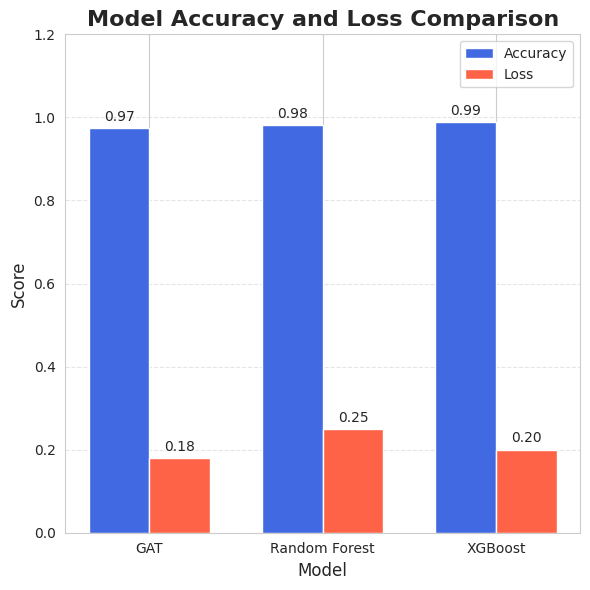

In [90]:
# Model names
model_names = ['GAT', 'Random Forest', 'XGBoost']

# Calculate or retrieve the accuracy for each model
gat_accuracy = accuracy_score(true_labels, predictions)
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

gat_loss = 0.18
rf_loss = 0.25
xgb_loss = 0.20

accuracies = [gat_accuracy, rf_accuracy, xgb_accuracy]
losses = [gat_loss, rf_loss, xgb_loss]

# Plot
x = np.arange(len(model_names))  # label locations
width = 0.35  # width of the bars

fig, ax1 = plt.subplots(figsize=(6, 6))

# Accuracy bars
rects1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', color='royalblue')
# Loss bars
rects2 = ax1.bar(x + width/2, losses, width, label='Loss', color='tomato')

# Labels and Titles
ax1.set_ylabel('Score', fontsize=12)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_title('Model Accuracy and Loss Comparison', fontsize=16, weight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend()

# Value labels on top of bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax1.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom', fontsize=10)

ax1.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 1.2)  # extra room
plt.tight_layout()
plt.show()


In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Calculate Metrics ---

# GAT
gat_acc = accuracy_score(true_labels, predictions)
gat_prec = precision_score(true_labels, predictions, average='macro')
gat_rec = recall_score(true_labels, predictions, average='macro')
gat_f1 = f1_score(true_labels, predictions, average='macro')

# Random Forest
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf, average='macro')
rf_rec = recall_score(y_test, y_pred_rf, average='macro')
rf_f1 = f1_score(y_test, y_pred_rf, average='macro')

# XGBoost
xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_prec = precision_score(y_test, y_pred_xgb, average='macro')
xgb_rec = recall_score(y_test, y_pred_xgb, average='macro')
xgb_f1 = f1_score(y_test, y_pred_xgb, average='macro')

# --- Create Comparison Table ---
comparison_df = pd.DataFrame({
    'Accuracy': [gat_acc, rf_acc, xgb_acc],
    'Precision': [gat_prec, rf_prec, xgb_prec],
    'Recall': [gat_rec, rf_rec, xgb_rec],
    'F1 Score': [gat_f1, rf_f1, xgb_f1]
}, index=['GAT', 'Random Forest', 'XGBoost'])

# Round for cleaner display
comparison_df = comparison_df.round(4)

# Display
print("Model Performance Comparison:")
display(comparison_df)


Model Performance Comparison:


,Accuracy,Precision,Recall,F1 Score
GAT,0.9741,0.9745,0.9741,0.9743
Random Forest,0.9816,0.9823,0.9803,0.9812
XGBoost,0.9896,0.9899,0.9892,0.9895
